In [274]:
# This is the 2nd step!
# 1. The transit search was run from the command line with e.g.:
#
#    python k2_superpig_search.py --fl step0-inputs/alltest > step1-eebls-results/alltest_results_2016May19.txt
#
#    (If you need to create the input (alltest), there is a cell below to help
#     ince ls * > file won't work on more than a few 1000 files)
#
# 2. This notebook (Step2_K2_Identify_Candidates) identifies candidate planets
%matplotlib inline

#import modules, including the codes used in this study
import numpy as np
from scipy import stats
import pylab
import matplotlib as plt
pylab.rcParams['axes.formatter.useoffset'] = False
import astropy.io.fits as fits
import glob
import statsmodels.robust.scale as sm
import time as systime
from tabulate import tabulate
import shutil
import string
import os
import math
from timeit import default_timer as timer
# new transit fitting package:  pip install batman-package
import batman

# our package
import k2_superpig_search as k2_sppg

In [275]:
# Some better plot defaults
label_size = 24
tick_size=20
%config InlineBackend.figure_format='retina'

# Load eebls results

In [276]:
# The file this script is located in is the superpig dir
print os.getcwd()

/Users/era/github/superpig-public


In [277]:
######### Locations
# Analysis dir:
superpig_dir = os.getcwd()
# Results from previous steps:
step0_dir = "step0-inputs/"
step1_dir = "step1-eebls-results/"
# Results from this step should go:
results_dir = "step2-candidate-results/"
# Light curves
lightcurve_dir = results_dir + "lightcurves/"

In [278]:
############## We only run one campaign/quarter at a time #########
quarter = "c04"
##############################################

In [279]:
# 1. You can store data for different campaigns in different folders/harddrives
# 2. Data is time stamped by the date run. If your run the eebls search across multiple days
#    you will need to have multiple entries in acceptableDates
# 3. However, the acceptableDateString doesn't deal with month crossings. Feel free to fix!

In [280]:
########################### Test (C00) #################################
if quarter == "test":
    eebls_data_dir_main = superpig_dir+"/testdata/"  # the test file in this directory
    eebls_results_dir = eebls_data_dir_main + quarter +"/"
    acceptableDates = ["2016May19"]
    acceptableDateString = "2016May"
    fits_search_prefix = "hlsp_k2sff_k2_lightcurve_"
    fits_search_suffix = "_kepler_v1_llc.fits"
    fits_search_string = fits_search_prefix + "*" + fits_search_suffix

########################### C00 #################################
if quarter == "c00":
    eebls_data_dir_main = "/Volumes/ERIDANI_BACKUP/Data/K2/"
    eebls_results_dir = eebls_data_dir_main + quarter +"/"
    acceptableDates = ["2016Feb24","2016Feb25"]
    acceptableDateString = "2016Feb"
    fits_search_prefix = "hlsp_k2sff_k2_lightcurve_"
    fits_search_suffix = "_kepler_v1_llc.fits"
    fits_search_string = fits_search_prefix + "*" + fits_search_suffix

########################### C01 #################################
if quarter == "c01":
    eebls_data_dir_main = "/Volumes/ERIDANI_BACKUP/Data/K2/"
    eebls_results_dir = eebls_data_dir_main + quarter +"/"
    acceptableDates = ["2016Feb25","2016Feb26","2016Feb27"]
    acceptableDateString = "2016Feb"
    fits_search_prefix = "hlsp_k2sff_k2_lightcurve_"
    fits_search_suffix = "_kepler_v1_llc.fits"
    fits_search_string = fits_search_prefix + "*" + fits_search_suffix

########################### C02 #################################
if quarter == "c02":
    eebls_data_dir_main = "/Users/era/Research/Projects/K2/datafiles/"
    eebls_results_dir = eebls_data_dir_main + quarter +"/"
    acceptableDates = ["2015Dec16", "2015Dec17","2016Mar02"]
    acceptableDateString = "2015Dec1"
    fits_search_prefix = "hlsp_k2sff_k2_lightcurve_"
    fits_search_suffix = "_kepler_v1_llc.fits"
    fits_search_string = fits_search_prefix + "*" + fits_search_suffix

########################### C03 #################################
if quarter == "c03":
    eebls_data_dir_main = "/Users/era/Research/Projects/K2/datafiles/"
    eebls_results_dir = eebls_data_dir_main + quarter +"/"
    acceptableDates = ["2015Dec16", "2015Dec17"]
    acceptableDateString = "2015Dec1"
    fits_search_prefix = "hlsp_k2sff_k2_lightcurve_"
    fits_search_suffix = "_kepler_v1_llc.fits"
    fits_search_string = fits_search_prefix + "*" + fits_search_suffix

########################### C04 #################################
if quarter == "c04":
    eebls_data_dir_main = "/Volumes/ERIDANI_BACKUP/Data/K2/"
    eebls_results_dir = eebls_data_dir_main + quarter +"/"
    acceptableDates = ["2015Dec16", "2015Dec17"]
    acceptableDateString = "2015Dec1"
    fits_search_prefix = "hlsp_k2sff_k2_lightcurve_"
    fits_search_suffix = "_kepler_v1_llc.fits"
    fits_search_string = fits_search_prefix + "*" + fits_search_suffix

########################### C05 #################################
if quarter == "c05":
    eebls_data_dir_main = "/Volumes/ERIDANI_BACKUP/Data/K2/"
    eebls_results_dir = eebls_data_dir_main + quarter +"/"
    acceptableDates = ["2016Feb13","2016Feb23","2016Feb27"]
    acceptableDateString = "2016Feb"
    fits_search_prefix = "hlsp_k2sff_k2_lightcurve_"
    fits_search_suffix = "_kepler_v1_llc.fits"
    fits_search_string = fits_search_prefix + "*" + fits_search_suffix

In [281]:
### Read in a presorted folder and follow everything in it
def files_in_folder(folder):
    matchString = "hlsp_k2sff_k2_lightcurve_*.png"
    filelist = glob.glob(folder + matchString)
    objList=[]
    for ff in filelist:
        obj = string.replace(string.split(string.replace(ff,folder,""),"-")[0], fits_search_prefix,"")
        objList.append(int(obj))
    return objList

In [282]:
######################## Very first step! ###############################################
# Create list of files TO search (i.e., have not run code before)
# Using the MOVING flag and 50 sigma outlier filter, searching 1 hrs to 3 days

# Which files are available? We want this even if you have already run the search
available_files = []
for dd in acceptableDates:
    dateFiles = glob.glob(eebls_results_dir + fits_search_string)
    for df in dateFiles:
        available_files.append(df)
available_files = list(set(available_files)) # glob bug: returns 2x each file!
available_files = sorted(available_files)    # if we rigorously sort from the get-go, it's better
print len(available_files)
print available_files[0]

# If you haven't searched yet, create sorted list of all files in a quarter
########################
create_input_file = False
########################
if create_input_file:
    gg = open(step0_dir+"/all"+quarter,"w")
    for aa in available_files:
        print >>gg, aa
    gg.close()

15779
/Volumes/ERIDANI_BACKUP/Data/K2/c04/hlsp_k2sff_k2_lightcurve_210302627-c04_kepler_v1_llc.fits


In [283]:
######### IF YOU HAVE NOT RUN THE SEARCH YET, DO THAT NOW #################
#
#    python k2_superpig_search.py --fl allfiles > allfiles_results.txt
#
# ... I'll wait...
#

In [284]:
# Create list_of_files_you_searched (ie, code has already been run)
# Note that we use glob because there are thousands of files -- ls can't cope beyond ~4K
print eebls_results_dir

eebls_files_all = []
for dd in acceptableDates:
    dateFiles = glob.glob(eebls_results_dir + "*eebls_spec_"+dd+".txt")
    for df in dateFiles:
        eebls_files_all.append(df)
eebls_files_all = sorted(eebls_files_all)
print len(eebls_files_all), eebls_files_all[0]

/Volumes/ERIDANI_BACKUP/Data/K2/c04/
15835 /Volumes/ERIDANI_BACKUP/Data/K2/c04/hlsp_k2sff_k2_lightcurve_210302627-c04_kepler_v1_eebls_spec_2015Dec16.txt


In [285]:
# This is to weed out duplicates should they sneak in
# e.g., by re-running an object on a later (but matching) date
# always takes the first file! so you may need to be clever to get the latest file (below)
eebls_objects = []; eebls_files_cleaned = []
for ff in eebls_files_all:
    corresponding = string.split(string.replace(ff,eebls_results_dir+fits_search_prefix,""),"-")[0]    
    if corresponding in eebls_objects:
        foo =1
    else:
        eebls_files_cleaned.append(ff)
        eebls_objects.append(corresponding)
eebls_files = eebls_files_cleaned
print len(eebls_files), eebls_files[-1]

15779 /Volumes/ERIDANI_BACKUP/Data/K2/c04/hlsp_k2sff_k2_lightcurve_211203589-c04_kepler_v1_eebls_spec_2015Dec17.txt


In [286]:
###### Remove subset of older files ######
#earlier_files = [string.replace(ii,"Oct22","Oct21") for ii in list(set(eebls_files_all) - set(eebls_files))]
#for ff in earlier_files:
#    os.remove(ff)

In [287]:
###### If you need to remove ALL files in old runs, rm isn't going to cut it: #####
#for mm in glob.glob(eebls_results_dir+"hlsp_k2sff_k2_lightcurve_*2016May*"):
#    os.remove(mm)

In [288]:
# Create a list file suitable for running eebls on (if, say, you have to rerun)
rerun_eebls_correct_order = False
if rerun_eebls_correct_order == True:
    gg = open("all_rerun.txt","w")
    for ee in eebls_files:
        yy = string.replace(ee,"_eebls_spec_2015Oct15.txt", "_llc.fits")
        zz = string.replace(yy,"_eebls_spec_2015Oct16.txt", "_llc.fits")
        print >>gg, zz
    gg.close()

In [289]:
# Function to load data (taking top file if more than one exists)
# Note that this function can be used to load any kind of two-column file, but by default load
#fileStringToMatch="eebls_spec*.txt"
fileStringToMatch="conditioned_data*.txt"

def get_data(epic_num, root_dir=eebls_results_dir, which_file=fileStringToMatch,verbose=False):
    data_file = glob.glob(root_dir + "*" + epic_num + "*" + which_file)
    if verbose:
        print data_file[0]
    data = np.loadtxt(data_file[0])
    return data[:,0], data[:,1]

## Collect search results if not already compiled (long step, 1 min/1000 files)

In [290]:
# File that you piped the output to, above
#   python k2_superpig_search.py --fl allfiles > allfiles_results_date.txt
if quarter == "c00":
    search_results_file = step1_dir+"allc00_results_2016Feb25.txt"
elif quarter == "c01":
    search_results_file = step1_dir+"allc01_results_2016Feb26.txt"
elif quarter == "c02":
    search_results_file = step1_dir+"allc02_results_2015Dec17.txt"
elif quarter == "c03":
    search_results_file = step1_dir+"allc03_results_2015Dec17.txt"
elif quarter == "c04":
    search_results_file = step1_dir+"allc04_results_2015Dec17.txt"
elif quarter == "c05":
    search_results_file = step1_dir+"allc05_results_2016Feb13.txt"
elif quarter == "test":
    search_results_file = step1_dir+"alltest_results_2016May19.txt"
    
print "Search file exists?", search_results_file,os.path.isfile(search_results_file)

# List of eebls results 
print "Number of files:",len(eebls_files)


Search file exists? step1-eebls-results/allc04_results_2015Dec17.txt True
Number of files: 15779


In [291]:
#2015 Jul 1 -- I'll figure out the right threshold later
snr_thresh = 10.
#2016 Feb 1 -- later is now
#snr_thresh = 5. # ugh, 5 is such a nightmare mess to sort through

In [292]:
######### Do you really want to remake the summary eebls file?  #########
# Will take a 15-30 min for a full campaign of data
compileSearchResults = False

# Get now time-date to write into output file
now = systime.strftime("%Y%b%d")
eebls_results_file = results_dir + "all_eebls_results_" +quarter+"_"+ now + ".txt"
print "EEBLS results will go here:", eebls_results_file
######################################################################

EEBLS results will go here: step2-candidate-results/all_eebls_results_c04_2016May19.txt


In [293]:
# Function to collect all EEBLS results into one text file
# This function does something subtly different than just collecting the eebls output though
# It actually re-finds the "best" (max power) period, and does NOT always agree!
# At the same time though, it uses the depth/duration from the eebls output 
def collect_eebls_results(file_list, search_file, output_file_name=eebls_results_file):
    #EEBLS returned parameters
    search_results = np.loadtxt(search_file, delimiter=', ')
    #Fortran starts indexing arrays at 1, but python starts at 0
    all_depth = search_results[:,3]
    all_qtran = search_results[:,4]
    all_in1 = search_results[:,5]
    all_in2 = search_results[:,6]
    
    all_epic_nums = list()
    all_bper = list()
    all_bpow = list()
    all_snr_bpow = list()
    for i in range(len(file_list)):
        current_file = file_list[i]
        epic_num = k2_sppg.get_epic_num(filename=current_file)
        if(epic_num != str(int(search_results[i,0]))):
            raise ValueError(epic_num + " != " + str(int(search_results[i,0])))
        all_epic_nums.append(k2_sppg.get_epic_num(filename=current_file))
    
        eebls_spec_file = np.loadtxt(current_file)
        periods = 24./eebls_spec_file[:,0]
        pows = eebls_spec_file[:,1]
    
        bpow = np.nanmax(pows)
        bper = periods[pows == bpow]
        all_bpow.append(bpow)
        all_bper.append(bper[0])

        mean_pow = np.nanmean(pows)
        #estimate stddev using median absolute deviation -- https://en.wikipedia.org/wiki/Median_absolute_deviation
        std_pow = 1.4826*sm.mad(pows)  
        all_snr_bpow.append((bpow - mean_pow)/std_pow)
 
    # was eebls_results_dir + output_file_name
    np.savetxt(output_file_name, zip(all_epic_nums, all_bper, all_bpow, all_snr_bpow,
                                     all_depth, all_qtran, all_in1, all_in2),
              header="K2_"+quarter+"_SuPerPiG_Search -- " + str(now) + \
               "\nEPIC num, bper (hours), bpow, SNR, depth, qtran, in1, in2", 
              fmt='%s', delimiter=', ')

In [294]:
search_results_file

'step1-eebls-results/allc04_results_2015Dec17.txt'

In [295]:
# Because this takes FOREVER to run, we should really make sure it's going to work first
gg = open(search_results_file,"r")
lines = gg.readlines()
for ii,line in enumerate(lines[1:]):
    elems = line.rstrip().split(",")
    corresponding = string.split(string.replace(eebls_files[ii],eebls_results_dir+"hlsp_k2sff_k2_lightcurve_",""),"-")[0]    
    # Hopefully, nothing prints out below:
    # Note: c00 does have stuff print, not sure why as nothing crashes
    if elems[0] != corresponding:
        print ii, elems[0], corresponding

In [296]:
############################# Long step! #################################
# For 13K files this took: 
# 5:12:50 - 5:24 or ~1 min/1000 files
start = timer()
print "Started at",start
if compileSearchResults == True:
    collect_eebls_results(eebls_files, search_results_file)
end = timer()
print(end - start) 
print "EEBLS output comes from",search_results_file
print "Compile results to",eebls_results_file
##########################################################################

Started at 1463710388.47
0.000195026397705
EEBLS output comes from step1-eebls-results/allc04_results_2015Dec17.txt
Compile results to step2-candidate-results/all_eebls_results_c04_2016May19.txt


In [297]:
if compileSearchResults == True:
    eebls_files = glob.glob(eebls_results_dir + "*eebls_spec_"+acceptableDateString+"*.txt")

    gg = open(search_results_file,"r")
    lines = gg.readlines()
    gg.close()
    print lines[-1], eebls_files[-1]

    #These need to match! In length and in order or else you get e.g.
    #   204000055 != 203604296
    print len(eebls_files), len(lines)-1 # header line

In [298]:
# Every time we run this search we make a new directory of promising results
# (so that older search criteria don't get overwritten)
# However eventually we figure it out and enshrine the right set of objects here:
if quarter == "c00":
    saved_promising_dir = results_dir+"promising-c00-2016Feb25/"
if quarter == "c01":
    saved_promising_dir = results_dir+"promising-c01-2016Feb26/"
if quarter == "c02":
    saved_promising_dir = results_dir+"promising-c02-2016Feb22/"
if quarter == "c03":
    saved_promising_dir = results_dir+"promising-c03-2016Feb22/"
if quarter == "c04":
    saved_promising_dir = results_dir+"promising-c04-2016Feb22/"
if quarter == "c05":
    saved_promising_dir = results_dir+"promising-c05-2016Feb16/"
if quarter == "test":
    saved_promising_dir = results_dir+"promising-test-2016May19/"

In [299]:
# Create directories to store promising results (or access them if rerunning)
# Note that the categories (weird, flat) are a little arbritrary and you might want
# to come up with a different way of triaging
now = systime.strftime("%Y%b%d")

######################
makeNewPromisingDir = False
######################

if makeNewPromisingDir:
    promising_dir = results_dir+"promising-"+quarter+"-"+now+"/"
    print promising_dir, os.path.exists(promising_dir)
    if not os.path.exists(promising_dir):
        os.makedirs(promising_dir)
    if not os.path.exists(promising_dir+"_transit-like/"):
        os.makedirs(promising_dir+"_transit-like/")
    if not os.path.exists(promising_dir+"_sinusoid/"):
        os.makedirs(promising_dir+"_sinusoid/")
    if not os.path.exists(promising_dir+"_eclipsing-binary/"):
        os.makedirs(promising_dir+"_eclipsing-binary/")
    if not os.path.exists(promising_dir+"_weird/"):
        os.makedirs(promising_dir+"_weird/")
    if not os.path.exists(promising_dir+"_flat/"):
        os.makedirs(promising_dir+"_flat/")

else:
    promising_dir = saved_promising_dir

# Now that we have compiled the search results, let's do science on them

In [300]:
# Note that final_eebls_results is in the superpig directory
# and is a copy of the file in the data directory (previous version)
if quarter == "c00":
    final_eebls_results = results_dir+"all_eebls_results_c00_2016Feb25.txt"
elif quarter == "c01":
    final_eebls_results = results_dir+"all_eebls_results_c01_2016Feb26.txt"
elif quarter == "c02":
    final_eebls_results = results_dir+"all_eebls_results_c02_2015Dec18.txt"
elif quarter == "c03":
    final_eebls_results = results_dir+"all_eebls_results_c03_2015Dec18.txt"
elif quarter == "c04":
    final_eebls_results = results_dir+"all_eebls_results_c04_2015Dec18.txt"
elif quarter == "c05":
    final_eebls_results = results_dir+"all_eebls_results_c05_2016Feb16.txt"
elif quarter == "test":
    final_eebls_results = results_dir+"all_eebls_results_test_2016May19.txt"


data = np.loadtxt(final_eebls_results, delimiter=', ')
all_epic_nums = np.array([(int(data[i,0])) for i in range(len(data[:,0]))])
all_bper = data[:,1] # hours!
all_bpow = data[:,2]
all_snr_bpow = data[:,3]
all_depth = data[:,4]
all_qtran = data[:,5]
all_in1 = data[:,6]
all_in2 = data[:,7]

In [301]:
# Confirm that the thruster period is not an issue anymore
# Note that the new peak period tends to be close to the window used, hmm.
mode_and_count = stats.mode(all_bper)
mode_period = mode_and_count[0][0] 
mode_period_count = mode_and_count[1][0]
thruster_period = 5.88
print "Is the problem period of 5.88 hours due to reactor thrusts masked?"
print mode_period_count,"objects have periods of",mode_period, "hours"

Is the problem period of 5.88 hours due to reactor thrusts masked?
137.0 objects have periods of 47.1588743177 hours


In [302]:
# Identifiying which indices were at the thruster period (or a multiple)
at_thruster_period = list(abs(all_bper - 8.*thruster_period)<0.1)
at_thruster_period.count(True)
at_thruster_indices=[i for i, x in enumerate(at_thruster_period) if x == True]
#print all_epic_nums[at_thruster_indices]

In [303]:
mode_period / thruster_period

8.0202167206972792

In [304]:
if quarter=="c02":
    look_for=[203518244] #c2
elif quarter == "c03":
    look_for=[206024342,206042996,206215704] #c3
else:
    look_for =[]
for ll in look_for:
    if ll in list(all_epic_nums):
        ii = list(all_epic_nums).index(ll)
        print ll, all_bper[ii], all_snr_bpow[ii], all_depth[ii],  all_qtran[ii]
    else:
        print "Didn't find",ii

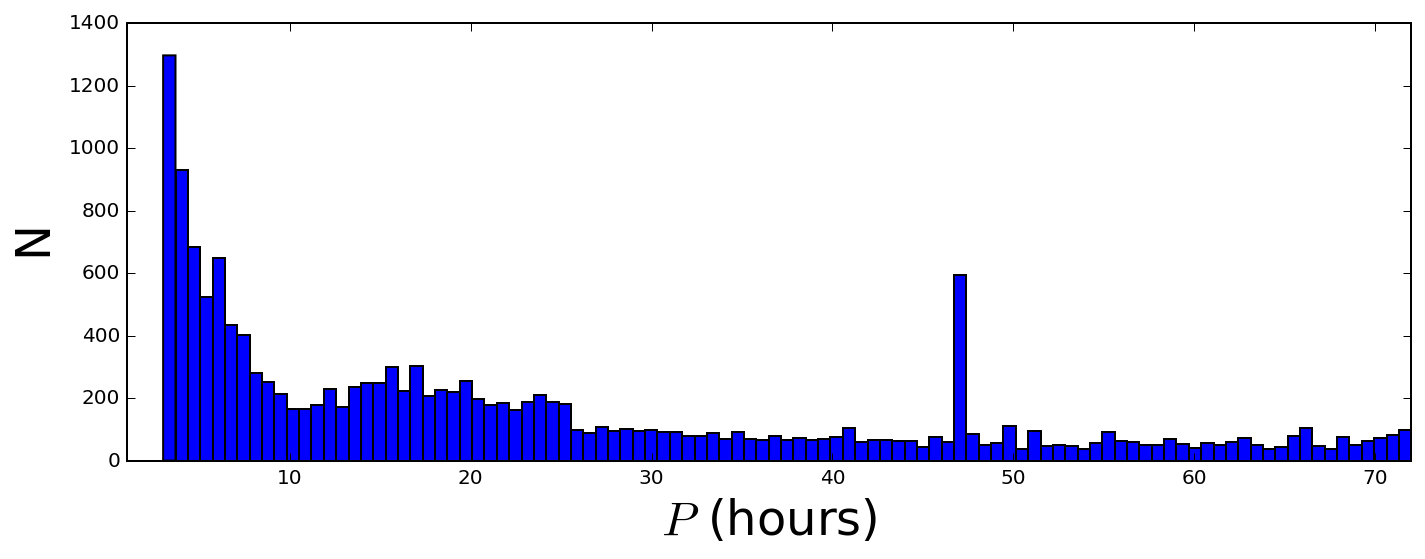

In [305]:
fig = pylab.figure(figsize=(10,4))
ax1 = fig.add_subplot(111)
pylab.hist(all_bper,bins=101)
ax1.set_xlim(1.,72.)
ax1.set_xlabel("$P$ (hours)",fontsize=label_size)
ax1.set_ylabel("N",fontsize=label_size)
fig.tight_layout()
pylab.savefig(results_dir+"figures/period_histogram_"+quarter+".png", dpi=300, bbox_tight='inches')

# Plot the process for a single planet

Example from Sanchis-Ojeda: do we recover it? EPIC201637175
   Need to rerun search for this one object (in c01)

Figure \label{fig:example_transit}

In [306]:
def plot_data_for_single_object(example_quarter, example_epic):
    example_file = eebls_results_dir+"hlsp_k2sff_k2_lightcurve_"+example_epic+ \
    "-"+example_quarter+"_kepler_v1_llc.fits"
    
    epic_num = k2_sppg.get_epic_num(filename=example_file)
    aper = "BESTAPER"

    hdulist = fits.open(example_file)
    HDU = hdulist[aper]
    #the K2 BJD time reference point
    t0 = HDU.header['BJDREFI']

    # For debugging, also get arclength
    timeA, arc = k2_sppg.get_time_series(HDU, which_flux="ARCLENGTH")
    time, flux = k2_sppg.get_time_series(HDU)
    
    time -= t0
    mn_time = np.nanmin(time)
    time -= mn_time

    detrended_time, detrended_flux = get_data(example_epic, root_dir=example_dir,
                                              which_file="conditioned_data*.txt", verbose=False)
    
    detrended_time -= t0
    detrended_time -= mn_time

    freqs, eebls_spec = get_data(example_epic, root_dir=example_dir,
                                 which_file="eebls_spec*.txt", verbose=False)
    
    bpow = np.nanmax(eebls_spec)
    bper = 1./freqs[eebls_spec == bpow][0]
    eebls_spec *= 1e3
   # print bper, bper*24
    
    num_bins=200
    binned_time, binned_flux, binned_err = k2_sppg.make_binned_transit(detrended_time % bper,
                                                                       detrended_flux,
                                                                       nb=num_bins)
    
    # Example continued: plot it
    fig = pylab.figure(figsize=(10, 10))

    ax1 = fig.add_subplot(221)
    ax1.scatter(time, flux, marker='.')
    ax1.set_ylabel('raw $\Delta F$',fontsize=label_size)
    ax1.set_ylim([0.99*min(flux),1.01*max(flux)])
#    ax1.set_xlabel("$T$ (days)", fontsize=label_size)
    ax1.xaxis.set_label_position("top")
    ax1.xaxis.set_major_formatter(pylab.NullFormatter())
    ax1.tick_params(axis='both', which='major', labelsize=tick_size)
    ax1.text(0.75, 0.85, "(a)", fontsize=36, transform = ax1.transAxes)

    ax2 = fig.add_subplot(223)
    ax2.scatter(detrended_time, detrended_flux*100., marker='.')
    #ax2.set_ylim([0.9*min(detrended_flux),1.1*max(detrended_flux)])
    ax2.set_xlabel('t (BJD - %i)' % (t0 + mn_time), fontsize=label_size)
    ax2.set_ylabel('detrended $\Delta F$ (%)', fontsize=label_size)
    ax2.tick_params(axis='both', which='major', labelsize=tick_size)
    ax2.text(0.75, 0.85, "(b)", fontsize=36, transform = ax2.transAxes)
    
    ind = eebls_spec > 0.
    ax3 = fig.add_subplot(222)
    ax3.plot(24./freqs[ind], eebls_spec[ind], color='blue')
    ax3.axvline(bper*24., color='red', ls='--', lw=6)
    ax3.plot(24./freqs[ind], eebls_spec[ind], color='blue')
    ax3.set_xlim([3., 72.])
    ax3.set_xlabel("$P$ (hours)", fontsize=label_size)
    ax3.set_ylabel("BLS spec (ppth)", fontsize=label_size)
    ax3.tick_params(axis='both', which='major', labelsize=tick_size)
    ax3.text(0.75, 0.85, "(c)", fontsize=36, transform = ax3.transAxes)
    ax3.yaxis.tick_right()
    ax3.yaxis.set_ticks_position('both')
    ax3.yaxis.set_label_position("right")
    ax3.xaxis.tick_top()
    ax3.xaxis.set_ticks_position('both')
    ax3.xaxis.set_label_position("top")

    ax4 = fig.add_subplot(224)
 #   ax4.scatter(binned_time*24., binned_flux*1e3)
    ax4.scatter(binned_time*24., binned_flux)
    ax4.set_xlim([0., bper*24.])
 #   ax4.set_ylim([min(binned_flux)*1e3-1, 1+max(binned_flux)*1e3])
    ax4.set_ylim([min(binned_flux), max(binned_flux)])
    ax4.set_xlabel("folded $t$ (hours)", fontsize=label_size)
  #  ax4.set_ylabel("binned $\Delta F$ (ppth)", fontsize=label_size)
    ax4.set_ylabel("binned $\Delta F$ (ppm)", fontsize=label_size)
    ax4.tick_params(axis='both', which='major', labelsize=20)
    ax4.text(0.75, 0.85, "(d)", fontsize=36, transform = ax4.transAxes)
    ax4.text(0.05, 0.05, "P="+str(round(bper*24.,8))+" hrs", fontsize=20, transform = ax4.transAxes)
    ax4.yaxis.tick_right()
    ax4.yaxis.set_ticks_position('both')
    ax4.yaxis.set_label_position("right")

    fig.tight_layout()
    pylab.savefig(results_dir+"figures/examples/example_"+example_epic+".pdf", dpi=300, bbox_tight='inches')
        

In [307]:
#### Change these: ###
print look_for
#example_quarter = "c02"
#example_epic = "203518244"
example_quarter ="c03"
example_epic = "206024342" 
#example_quarter = "c04"
#example_epic = "210414957"
example_quarter = "c01"
example_epic = "201637175"
#example_quarter ="c05"
#example_epic = "211934173" 
example_quarter = "c00"
example_epic = "202073210"
example_dir = eebls_results_dir

[]


In [308]:
# A four panel example plot showing the detection process
plot_example = False
if plot_example:
    plot_data_for_single_object(example_quarter, example_epic)

# Proceed to search whole campaign

In [309]:
# nb= number of bins and must match the nb in the eebls search that you ran!
def convert_in1_to_phi0(in1, nb=200):
    #converts a mid-transit index to a phase
    phase = np.linspace(0., 1., nb)
    return phase[in1]

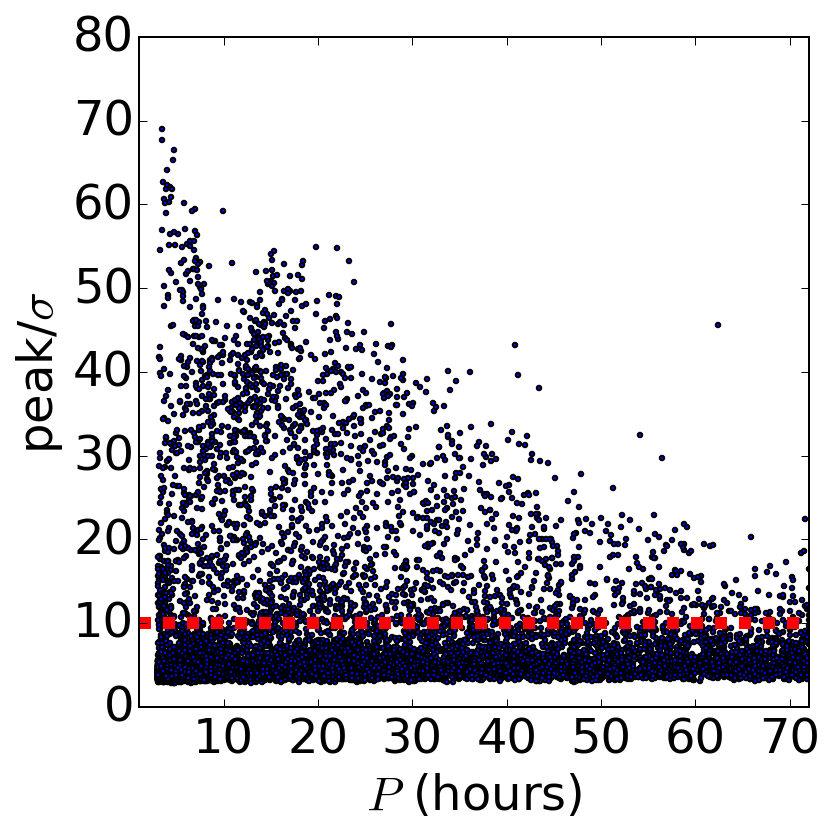

In [310]:
fig = pylab.figure(figsize=(6,6))

ax1 = fig.add_subplot(111)
ax1.scatter(all_bper, all_snr_bpow, marker='.')
ax1.axhline(snr_thresh, color='red', ls='--', lw=6)

ax1.set_xlim([1., 72.])
ax1.set_ylim([0.,80.])
ax1.set_xlabel("$P$ (hours)",fontsize=label_size)
ax1.set_ylabel("peak/$\sigma$",fontsize=label_size)
ax1.tick_params(axis='both', which='major', labelsize=24)
fig.savefig(results_dir+"figures/final_eebls_periods_"+quarter+".pdf", dpi=300, bbox_inches="tight")

#Generate full and truncated (manuscript) tables
table = [[int(all_epic_nums[i]), "%8.5f" % all_bper[i], 
          all_depth[i]*1e6, "%8.5f" % (all_qtran[i]*all_bper[i]), 
          "%2.0f" % all_snr_bpow[i], "%7.5f" % convert_in1_to_phi0(all_in1[i])] 
         for i in range(len(all_bper))]

#manuscript_table = tabulate(table[:1], 
#                            headers=["EPIC","Period (hours)", "Depth (ppm)", "Duration (hours)", "EEBLS SNR", 
#                                     "Phase"],
#                            tablefmt="latex")
#manuscript_table_file_name = results_dir+"eebls_candidates_manuscript.tex"
#manuscript_table_file = open(manuscript_table_file_name, "w")
#manuscript_table_file.write(manuscript_table)
#manuscript_table_file.close()

full_table = tabulate(table, 
                      headers=["EPIC","Period (hours)", "Depth (ppm)", "Duration (hours)", "EEBLS SNR", "Phase"], 
                      tablefmt="latex")
full_table_file_name = results_dir+"eebls_candidates_"+quarter+"_all.tex"
full_table_file = open(full_table_file_name, "w")
full_table_file.write(full_table)
full_table_file.close()

In [311]:
print snr_thresh, len(all_epic_nums)

10.0 15779


2448


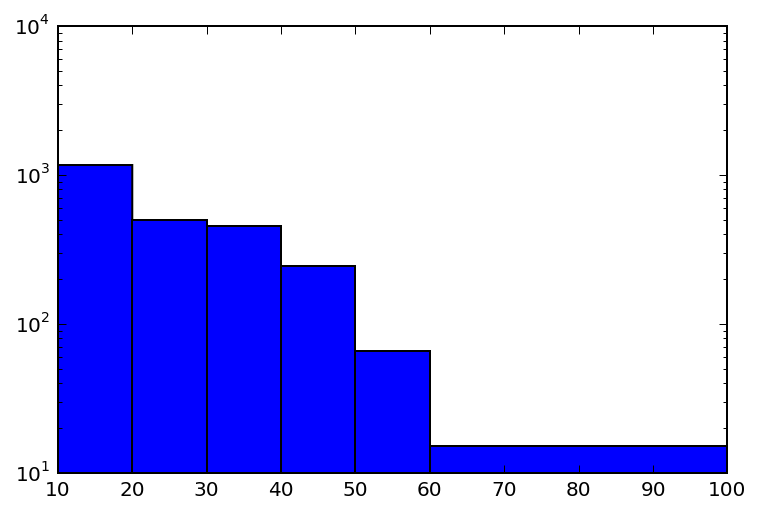

In [312]:
# Per referee comment about snr_thresh being very non-Gaussian, plot histogram
pylab.hist(all_snr_bpow,bins=[10, 20, 30, 40, 50, 60,100])
pylab.yscale('log', nonposy='clip')
above_thresh = list(all_snr_bpow >= 10)
print above_thresh.count(True)

In [313]:
#Filter out transits with SNR too small AND we only care about less than 1 d
ind = (all_snr_bpow >= snr_thresh) & (all_bper <= 24.0)
print quarter, list(ind).count(True)
all_epic_nums = all_epic_nums[ind]
all_bper = all_bper[ind]
all_bpow = all_bpow[ind]
all_snr_bpow = all_snr_bpow[ind]
all_depth = all_depth[ind]
all_qtran = all_qtran[ind]
all_in1 = all_in1[ind]
all_in2 = all_in2[ind]
# add derived quantities
all_dur = all_qtran*all_bper

c04 1480


In [314]:
# Count for Adams 2016 (SNR and 1 day): 
# c00: 757
# c01: 505
# c02: 1251 
# c03: 419
# c04: 1480
# c05: 1032
# Total = 5444
757 + 505 + 1251 +419 +1480 + 1032

5444

In [315]:
# Testing: we say that the minimum density for FGK stars is (Jackson 2013)
# log(ρ⋆/ρ⊙) = −0.3 (Cox 2000)
# So for an M dwarf: https://en.wikipedia.org/wiki/Red_dwarf
# Stellar class	Mass(M☉)	Radius(R☉)
# M0V	60%	62%
# M9V	7.5%	8%
def density(m,r):
    return m/(4/3*np.pi*r**3)
print "F0",density(1.6,1.5)
print "Sun",density(1,1)
print "M",density(0.6,0.62)
print "F over Sun", math.log(density(1.6,1.5)/density(1,1),10)
print "M over Sun", math.log(density(.6,.62)/density(1,1),10)

F0 0.150902464561
Sun 0.318309886184
M 0.801357506085
F over Sun -0.324153794511
M over Sun 0.400976181889


In [316]:
#Eqn 3 from Jackson+ (2013 -- http://adsabs.harvard.edu/abs/2013ApJ...779..165J)
#  incorporating the relationship between stellar density and transit duration to 
#  implement a cut-off in transit duration (although the Gamma given in that paper is wrong).
Gamma = 0.003632
hours_to_years = 24.*365.25
pad_factor = 1./24. ## pad by two kepler exposure times since durations get averaged out longer
max_qtran = np.arcsin(Gamma*(all_bper/hours_to_years)**(-2./3))/np.pi + pad_factor
#A planet twice Jupiter's size transiting the Sun
# 2*R_Jup around 0.4 R_Sun star
print (2.*69911)**2 / (.4*696300)**2
max_depth = 0.25
transit_depth_threshold = 0.02/1e-6
print "Right duration",list(all_qtran <= max_qtran).count(True)
print "Right depth",list(all_depth <= max_depth).count(True)
ind = (all_qtran <= max_qtran) & (all_depth <= max_depth)
print "Both right",list(ind).count(True)
# Was set (wrongly) at 0.02
prior_depth = 0.02
prior_ind = (all_qtran <= max_qtran) & (all_depth <= prior_depth)

0.252021879967
Right duration 154
Right depth 1474
Both right 152


In [317]:
if quarter == "c02":
    all_c02_cands=[202971774, 203533312, 205152172, 205377483] #,203518244]
    all_c02_inds = [list(all_epic_nums).index(ii) for ii in all_c02_cands]
    print all_bper[all_c02_inds]
    print max_qtran[all_c02_inds]
    print all_qtran[all_c02_inds]
elif quarter == "c01":
    all_cands = []
    all_inds = [list(all_epic_nums).index(ii) for ii in all_cands]
    print all_bper[all_inds]
    print max_qtran[all_inds]
    print all_qtran[all_inds]

In [318]:
keep_epic_nums = np.copy(all_epic_nums[ind])
keep_dur = np.copy(all_dur[ind])
keep_depth= np.copy(all_depth[ind])

In [319]:
# Want to know what happened to a specific object?
print look_for
try:
    iii = list(all_epic_nums).index(203533312 )
    print "Object",all_epic_nums[iii], "Period (hrs)", all_bper[iii], "Index", iii
    print "SNR", all_snr_bpow[iii], "-- more than cutoff", snr_thresh,"?",all_snr_bpow[iii] >= snr_thresh
    print "Duration", all_qtran[iii], "-- less than cutoff", max_qtran[iii],"?",all_qtran[iii] <= max_qtran[iii]
    print "Depth", all_depth[iii], "-- less than cutoff?", max_depth,"?",all_depth[iii] <= max_depth
except:
    print "Not in list"

[]
Not in list


In [320]:
# AFTER you have identified good candidates, add 'em in to the plot (different symbols)
plot_best_candidates = True
if plot_best_candidates:
    print promising_dir+"_transit-like/"
    candidate_list = files_in_folder(promising_dir+"_transit-like/")
 #   print len(candidate_list)
#    print candidate_list
    cand_depth=[]; cand_dur =[]
    for cc in candidate_list:
        cand_ind = list(all_epic_nums).index(cc)
        cand_depth.append(all_depth[cand_ind])
        cand_dur.append(all_dur[cand_ind])
    cand_depth = np.array(cand_depth)
    cand_dur = np.array(cand_dur)

step2-candidate-results/promising-c04-2016Feb22/_transit-like/


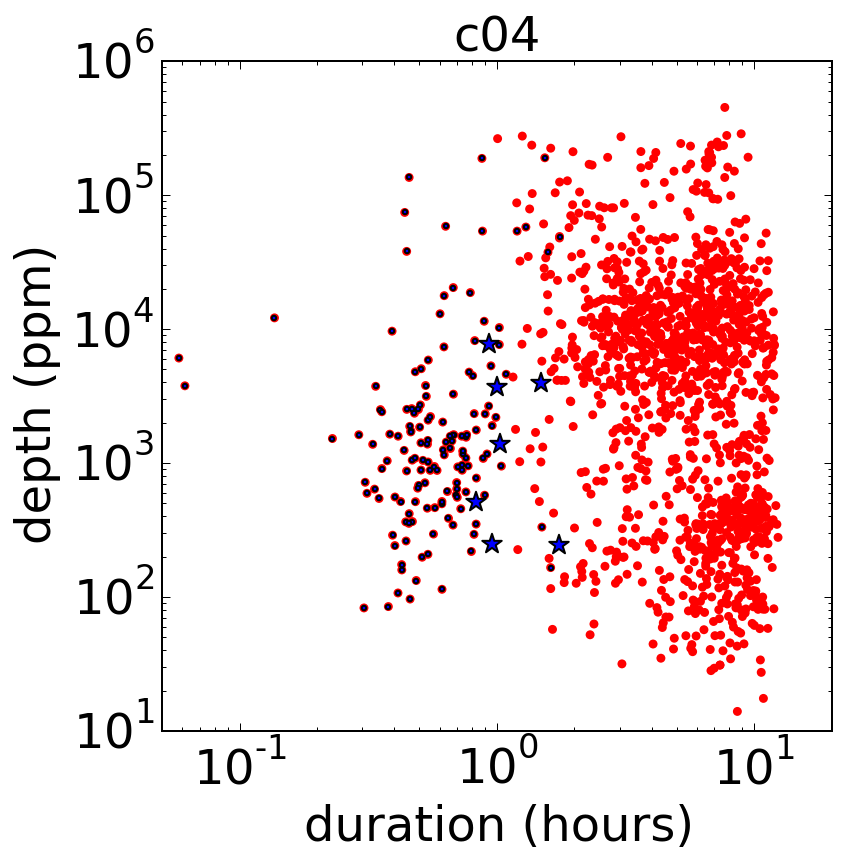

In [321]:
fig = pylab.figure(figsize=(6,6))

ax1 = fig.add_subplot(111)
ax1.scatter(all_dur, all_depth*1e6, edgecolor='None', facecolor='red')
ax1.scatter(keep_dur, keep_depth*1e6, marker='.')
if plot_best_candidates:
    ax1.scatter(cand_dur,cand_depth*1e6, facecolor='blue', marker='*', s=105)

#ax1.axhline(transit_depth_threshold, color='blue', ls='--', lw=6)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim([0.05, 20])
ax1.set_ylim([10, 1e6])
ax1.set_xlabel("duration (hours)",fontsize=label_size)
ax1.set_ylabel("depth (ppm)",fontsize=label_size)
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.set_title(quarter,fontsize=label_size)

fig.savefig(results_dir+"figures/duration-depth_threshold_"+quarter+".pdf", dpi=300, bbox_inches="tight")

## Inspection: era to look at black points (right duration/depth/SNR)

In [322]:
# Which files are nominally good?
len(keep_epic_nums)

152

In [323]:
# When I changed duration from 0.02 to 0.25 I only wanted to sift through the new ~10 objects
correct_depth = False
if correct_depth:
    extra_depth_objects = missing_set
    print len(extra_depth_objects)
    for ee in extra_depth_objects:
        match = eebls_results_dir+"hlsp_k2sff_k2_lightcurve_"+str(ee)+"-"+quarter+"_kepler_v1_binned_transit_"+acceptableDateString+"*.png"
        matching = glob.glob(match)
        shutil.copy(matching[-1], promising_dir) # Please only copy LATEST png file!

In [324]:
# When I reran the search with more output precision (this got rid of a LOT of flat curves!)
# I needed to be sure we didn't lose any objects I had flagged as good
# (or if we did that I understood why)
def copy_new_to_old(old_dir):
    print "From",promising_dir, "to",old_dir
    newfiles = files_in_folder(promising_dir)
    old_files = files_in_folder(old_dir)
    for nn in newfiles:
        if nn in old_files:
            match = eebls_results_dir+"hlsp_k2sff_k2_lightcurve_"+str(nn)+"-"+"*"+"_kepler_v1_binned_transit_"+acceptableDateString+"*.png"
            matching = glob.glob(match)
            shutil.copy(matching[-1], old_dir) # Please only copy LATEST png file!

In [325]:
if makeNewPromisingDir:
    print "Total number of promising candidates",len(keep_epic_nums)
    for ee in keep_epic_nums:
        match = eebls_results_dir+"hlsp_k2sff_k2_lightcurve_"+str(ee)+"-"+"*"+"_kepler_v1_binned_transit_"+acceptableDateString+"*.png"
        matching = glob.glob(match)
        shutil.copy(matching[-1], promising_dir) # Please only copy LATEST png file!

## Load 'em all in Preview and decide which to follow

Sort through (by hand for now) each image in the main promising diretory and put it in the appropriate subfolder (e.g. _transit-like)

How to open many files from command line:
   open -a Preview \*202733088\*binned\*

In [326]:
# First look at candidates tagged "transit-like":
tl = files_in_folder(promising_dir+"_transit-like/")
weird = files_in_folder(promising_dir+"_weird/")
sin = files_in_folder(promising_dir+"_sinusoidal/")

In [327]:
# We want to rerun these at higher SNR because some may be chopped
print tl
# Export to list then run (note extra flag):
#    python k2_superpig_search.py --highersnr --fl a1 > allc05_results_16Feb2016.txt
#

[210414957, 210605073, 210707130, 210754505, 210954046, 210961508, 211152484]


In [328]:
eb_list = files_in_folder(promising_dir+"_eclipsing-binary/")

print len(eb_list)
print eb_list

16
[210404228, 210434247, 210574135, 210593417, 210659779, 210662654, 210663545, 210664740, 210675130, 210821360, 210843708, 210863062, 210932768, 210941737, 210954667, 211012889]


In [329]:
# Add in "missing" candidate that Vanderburg found (so we can fit it later)
candidate_list = files_in_folder(promising_dir+"_transit-like/")#+[203518244]
#candidate_list = files_in_folder(promising_dir+"_weird/")
print len(candidate_list)
print candidate_list

7
[210414957, 210605073, 210707130, 210754505, 210954046, 210961508, 211152484]


In [330]:
# still in keep? This is a good check if you recently changed your search e.g. SNR requirements
for cc in candidate_list:
    foo = cc in keep_epic_nums
    print cc, foo

210414957 True
210605073 True
210707130 True
210754505 True
210954046 True
210961508 True
211152484 True


Now that we have identified all of our candidates, let's refine their properties and output them for future analysis

## 1. Refine periods of candidates

In [331]:
#refine_list = keep_epic_nums
refine_list = candidate_list
print len(refine_list)
#refine_list = [202971774, 203533312, 205152172, 205377483, 203027459]
should_refine_periods = True # if False, reload

7


In [332]:
def get_init_depth_period_for_epic(epic_num):
    for ii,ee in enumerate(all_epic_nums):
        if str(ee) == str(epic_num):
            return all_depth[ii], all_bper[ii]
    # No matches
    return "NA","NA"

In [333]:
def refine_period(epic_num, nominal_period_hrs):
    snr_conditioned_time, snr_conditioned_flux = get_data(str(epic_num))
    
    min_period = 0.98*nominal_period_hrs/24.
    max_period = 1.02*nominal_period_hrs/24.
    num_periods = 10000
    period_list = np.linspace(min_period, max_period, num_periods+1)
    
    depths = np.array([])
    durations = np.array([])
    periods = np.array([])
    in1s = np.array([])
    in2s = np.array([])
    freqs, eebls_spec, bper, bpow, depth, qtran, in1, in2 = k2_sppg.apply_eebls(
        snr_conditioned_time, snr_conditioned_flux, num_periods=num_periods, 
        min_period=min_period, max_period=max_period,nb=200)
             
    return depth, bper

In [334]:
#test = 205152172
#nom = get_init_depth_period_for_epic(test )[1]
#print nom
#refine_period(test, nom)

In [335]:
start = timer()
if should_refine_periods == True:
    refined_periods = []
    for ee in refine_list:
        nominal_period = get_init_depth_period_for_epic(ee)[1]
        depths, bper = refine_period(ee, nominal_period)
        refined_periods.append(bper)
    #    print ee, bper*24., nominal_period, bper, nominal_period/24.
    refined_candidates = refine_list
end = timer()
print(end - start) 
# 20 obj in 5.4 sec, so, 200 obj in ~1 min

4.5761961937


In [336]:
refined_period_file = results_dir+"refined_periods_"+quarter+".tsv"

if should_refine_periods == True:
    # Output periods to file
    gg = open(refined_period_file,"w")
    print >>gg, "\t".join(["Candidate","Period_hr","Period_d"])
    for ii in range(len(refine_list)):
        print >>gg, "\t".join([str(refine_list[ii]), str(refined_periods[ii]*24), str(refined_periods[ii])])

    gg.close()

else:
    # Import periods from file
    gg = open(refined_period_file,"r")
    lines = gg.readlines()
    refined_candidates = []
    refined_periods = []
    for line in lines[1:]:
        elems = line.rstrip().split("\t")
        refined_candidates.append(eval(elems[0]))
        refined_periods.append(eval(elems[2])) # days, same as original

refined_candidates = list(refined_candidates)

In [337]:
print len(refined_periods), len(refined_candidates)

7 7


In [338]:
### We don't want zero periods
nonzero_periods=[]; nonzero_candidates=[]; zeroes=[]
for ii in range(len(refined_periods)):
    if refined_periods[ii] > 0:
        nonzero_periods.append(refined_periods[ii])
        nonzero_candidates.append(refined_candidates[ii])
    else:
        zeroes.append(refined_candidates[ii])
print len(nonzero_candidates)
print zeroes

7
[]


In [339]:
follow_list = nonzero_candidates
follow_periods = nonzero_periods
print len(follow_list)

7


In [340]:
start = timer()
if should_refine_periods == True:
    refined_eb_periods = []
    for ee in eb_list:
        nominal_period = get_init_depth_period_for_epic(ee)[1]
        depths, bper = refine_period(ee, nominal_period)
        refined_eb_periods.append(bper)
    refined_eb_candidates = eb_list
    #    print ee, bper*24., nominal_period, bper, nominal_period/24.
end = timer()
print(end - start) 
# 20 obj in 5.4 sec, so, 200 obj in ~1 min

10.022662878


In [341]:
refined_eb_period_file = results_dir+"refined_periods_eb_"+quarter+".tsv"

if should_refine_periods == True:
    # Output periods to file
    gg = open(refined_eb_period_file,"w")
    print >>gg, "\t".join(["Candidate","Period_hr","Period_d"])
    for ii in range(len(eb_list)):
        print >>gg, "\t".join([str(eb_list[ii]), str(refined_eb_periods[ii]*24),
                               str(refined_eb_periods[ii])])

    gg.close()

# Rerun eebls search with different search periods (optional)

It's possible you may want to run the eebls search for a longer period; here's how:

In [342]:
rerun_longer_period = False

In [343]:
new_min_period = 3.0 #hours
new_max_period = 100.0
#longer_list = [206100889]
longer_list = candidate_list
#longer_list = eb_list
print len(longer_list)

7


In [344]:
# start at 1 rather than 3 hours, and go out to 2-3 days (as warranted)
def rerun_eebls_longer(obj, low_per=3., high_per =72.):
    detrended_time, detrended_flux = get_data(str(obj),
                                            root_dir=eebls_results_dir,
                                            which_file="conditioned_data*.txt")
  
    freqs3, p3, bper3, bpow3, depth3, qtran3, in13, in23 = k2_sppg.apply_eebls(detrended_time,
                                                                   detrended_flux,
                                                                   num_periods=10000,
                                                                   min_period=low_per/24,
                                                                   max_period=high_per/24.,
                                                                   nb=200, qmi=0.02, qma=0.5)
    return freqs3, p3, bper3, bpow3, depth3, qtran3, in13, in23

In [345]:
if rerun_longer_period:
    longer_periods=[]
    start = timer()
    for obj in longer_list:
        freqs3, p3, bper3, bpow3, depth3, qtran3, in13, in23 = rerun_eebls_longer(obj,
                                                                                  low_per=new_min_period, high_per =new_max_period)
        print obj,bper3 # days

        longer_periods.append(bper3)
    end = timer()
    print (end-start)

# Best period to use (after all this rerunning and refining)

In [346]:
print longer_list
print refined_candidates

[210414957, 210605073, 210707130, 210754505, 210954046, 210961508, 211152484]
[210414957, 210605073, 210707130, 210754505, 210954046, 210961508, 211152484]


In [347]:
def get_best_period_days(obj, force_original =False, use_longer=False, verbose=True):
    if (obj in refined_candidates) & (force_original==False):
        if verbose:
            print "period was refined"
        period = refined_periods[list(refined_candidates).index(obj)]
    elif (obj in refined_eb_candidates) & (force_original==False):
        if verbose:
            print "EB period was refined"
        period = refined_eb_periods[list(refined_eb_candidates).index(obj)]
    else:
        if verbose:
            print "original eebls period"
        depth, period = get_init_depth_period_for_epic(obj)
        period = period / 24.
    # ... but if we are using longer periods that takes precedent
    if (use_longer) & (obj in longer_list):
        if verbose:
            print "using longer period"
        jj = longer_list.index(obj)
        period = longer_periods[jj]
    return period

if len(candidate_list) > 0:
    period = get_best_period_days(candidate_list[0],use_longer=False)
    print candidate_list[0], period

if len(eb_list) > 0:
    period_eb = get_best_period_days(eb_list[0],use_longer=False)
    print eb_list[0], period_eb

period was refined
210414957 0.97001575141
EB period was refined
210404228 0.559971318736


In [348]:
# exclude bad sectors of data
def exclude_bad_times(obj, detrended_time, detrended_flux):
    if obj == 205100995:
        bad_times = [2456915.,2456926.]
    else:
        bad_times = None
    if bad_times == None:
        return detrended_time, detrended_flux
    else:
        good_times = []; good_fluxes=[]
        for ii, tt in enumerate(detrended_time):
            if (tt < bad_times[0]) | (tt > bad_times[1]):
                good_times.append(tt)
                good_fluxes.append(detrended_flux[ii])
        return np.array(good_times), np.array(good_fluxes)

# Diagnostic plots: 2 x P, 3 x P

We want to plot objects folded at different periods to search for odd-even variations and other binary star signals

In [349]:
######## Make a plot of all candidates
def make_diag_plot(obj,  fileName,nCols=1,extra_fold_factor=[],
                   cond_file_to_use="conditioned_data*.txt",longer=False, plot_binned=False):
    # Set number of rows/columns for plotting
    nRows = 2
    nPlots = 2 + len(extra_fold_factor)
    fig_length = nPlots * 3

    fold_period = get_best_period_days(obj,use_longer=longer)
   
    fig = pylab.figure(figsize=(10, fig_length))
    detrended_time1, detrended_flux1 = get_data(str(obj), root_dir=eebls_results_dir,
                                              which_file=cond_file_to_use)
    detrended_time, detrended_flux = exclude_bad_times(obj, detrended_time1, detrended_flux1)
    
    binned_time, binned_flux, binned_err = k2_sppg.make_binned_transit(detrended_time % fold_period,
                                                                       detrended_flux, nb=200)
   
    ax1 = fig.add_subplot(nPlots, 1, 1)
    ax1.scatter(detrended_time,detrended_flux)
    ax1.set_ylim([1.1*min(detrended_flux),1.1*max(detrended_flux)])
    ax1.set_title(str(obj)+" detrended")
    # arbitrary length of time to plot (not full length)
  #  ax1.set_xlim([min(detrended_time),10+min(detrended_time)])
  #  ax1.set_xlim([max(detrended_time)-20,max(detrended_time)])
    ax1.set_xlim([min(detrended_time),max(detrended_time)])

    ax1.yaxis.tick_right()
    ax1.yaxis.set_ticks_position('both')
    ax1.yaxis.set_label_position("right")

    ax2 = fig.add_subplot(nPlots, 1, 2)
    if plot_binned:
        ax2.scatter(binned_time , binned_flux)
        ax2.set_title(str(obj)+" binned")
        ax2.set_ylim([1.1*min(binned_flux),1.1*max(binned_flux)])
    else:
        ax2.scatter(detrended_time % fold_period,detrended_flux)
        ax2.set_title(str(obj)+" unbinned")
        ax2.set_ylim([1.1*min(detrended_flux),1.1*max(detrended_flux)])

    ax2.text(0.05, 0.85, "P_fold = "+str(fold_period)+" (best eebls)", fontsize=16,
             transform = ax2.transAxes)
    ax2.set_xlim([0,fold_period])
    ax2.yaxis.tick_right()
    ax2.yaxis.set_ticks_position('both')
    ax2.yaxis.set_label_position("right")
     
    for ii in range(len(extra_fold_factor)):
        ax = fig.add_subplot(nPlots, 1, 3+ii)
        if plot_binned:
            binned_time, binned_flux, binned_err = k2_sppg.make_binned_transit(detrended_time % (extra_fold_factor[ii]*fold_period),
                                                                       detrended_flux, nb=200)
            ax.scatter(binned_time , binned_flux)
            ax.set_title(str(obj)+" binned")
            ax.set_ylim([1.1*min(binned_flux),1.1*max(binned_flux)])
        else:
            ax.scatter(detrended_time % (extra_fold_factor[ii]*fold_period), detrended_flux)
            ax.set_title(str(obj)+" unbinned")
            ax.set_ylim([1.1*min(detrended_flux),1.1*max(detrended_flux)])

        ax.text(0.05, 0.85, "P_fold * "+str(extra_fold_factor[ii]),
                fontsize=16, transform = ax.transAxes)
        ax.set_xlim([0,extra_fold_factor[ii]*fold_period])
        ax.yaxis.tick_right()
        ax.yaxis.set_ticks_position('both')
        ax.yaxis.set_label_position("right")
    ax.set_xlabel("t (d)", fontsize=16)

    fig.tight_layout()
    pylab.savefig(fileName, dpi=300, bbox_tight='inches')

In [350]:
diag_objects = candidate_list
#diag_objects = []
#diag_objects = [ candidate_list[25] ]
#diag_objects = [202920095  ]

period was refined
period was refined
period was refined
period was refined
period was refined
period was refined
period was refined


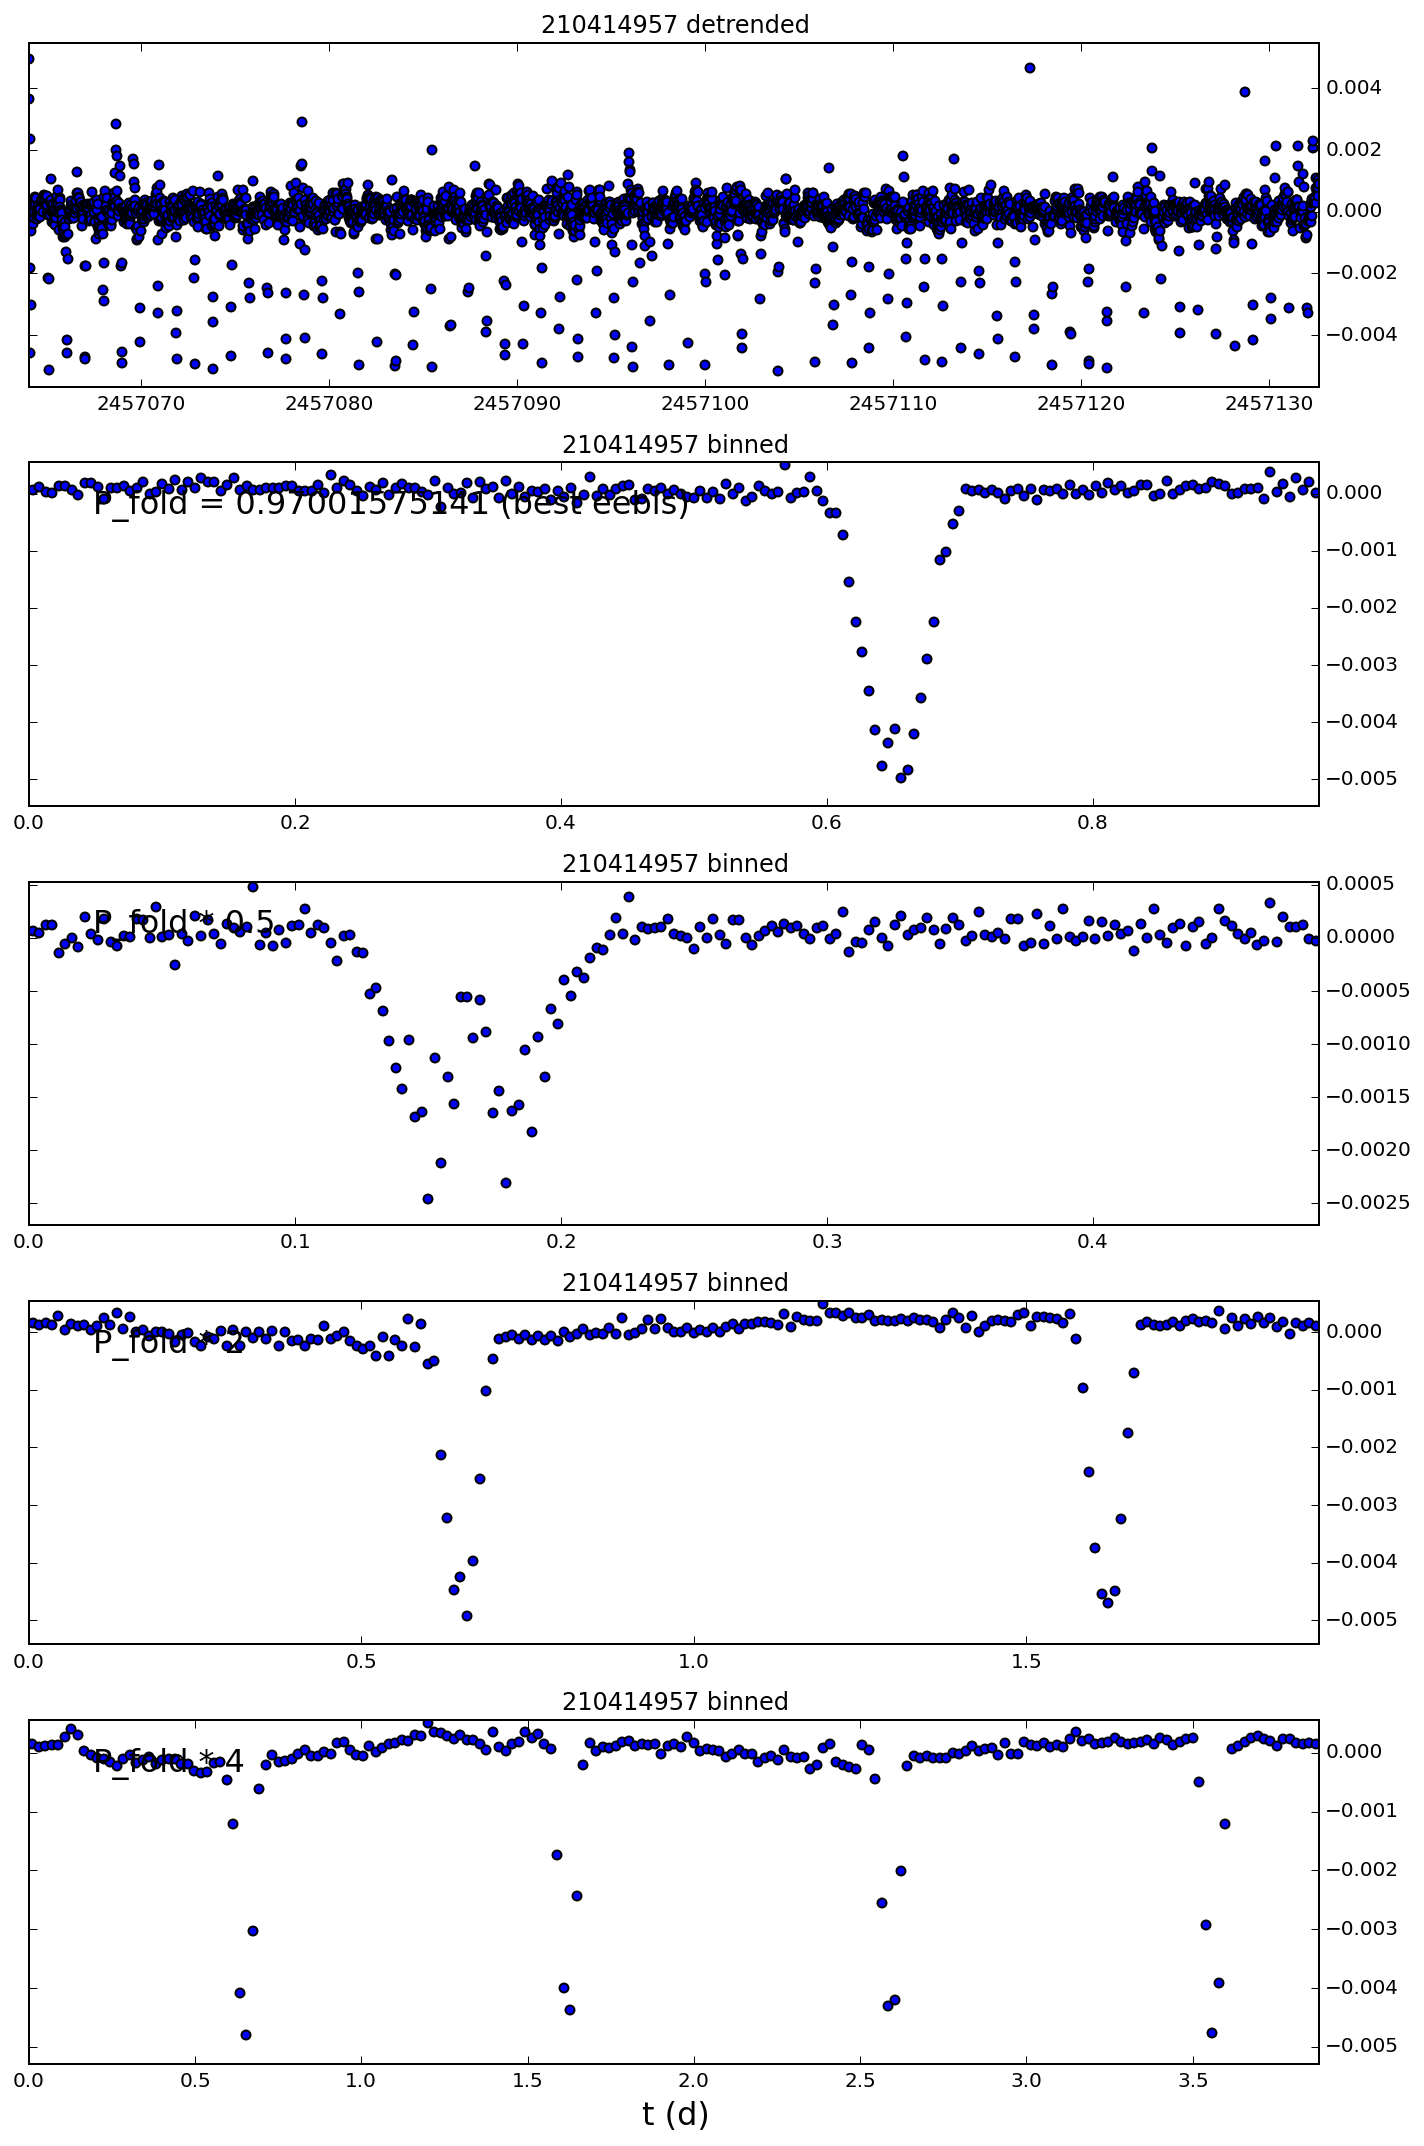

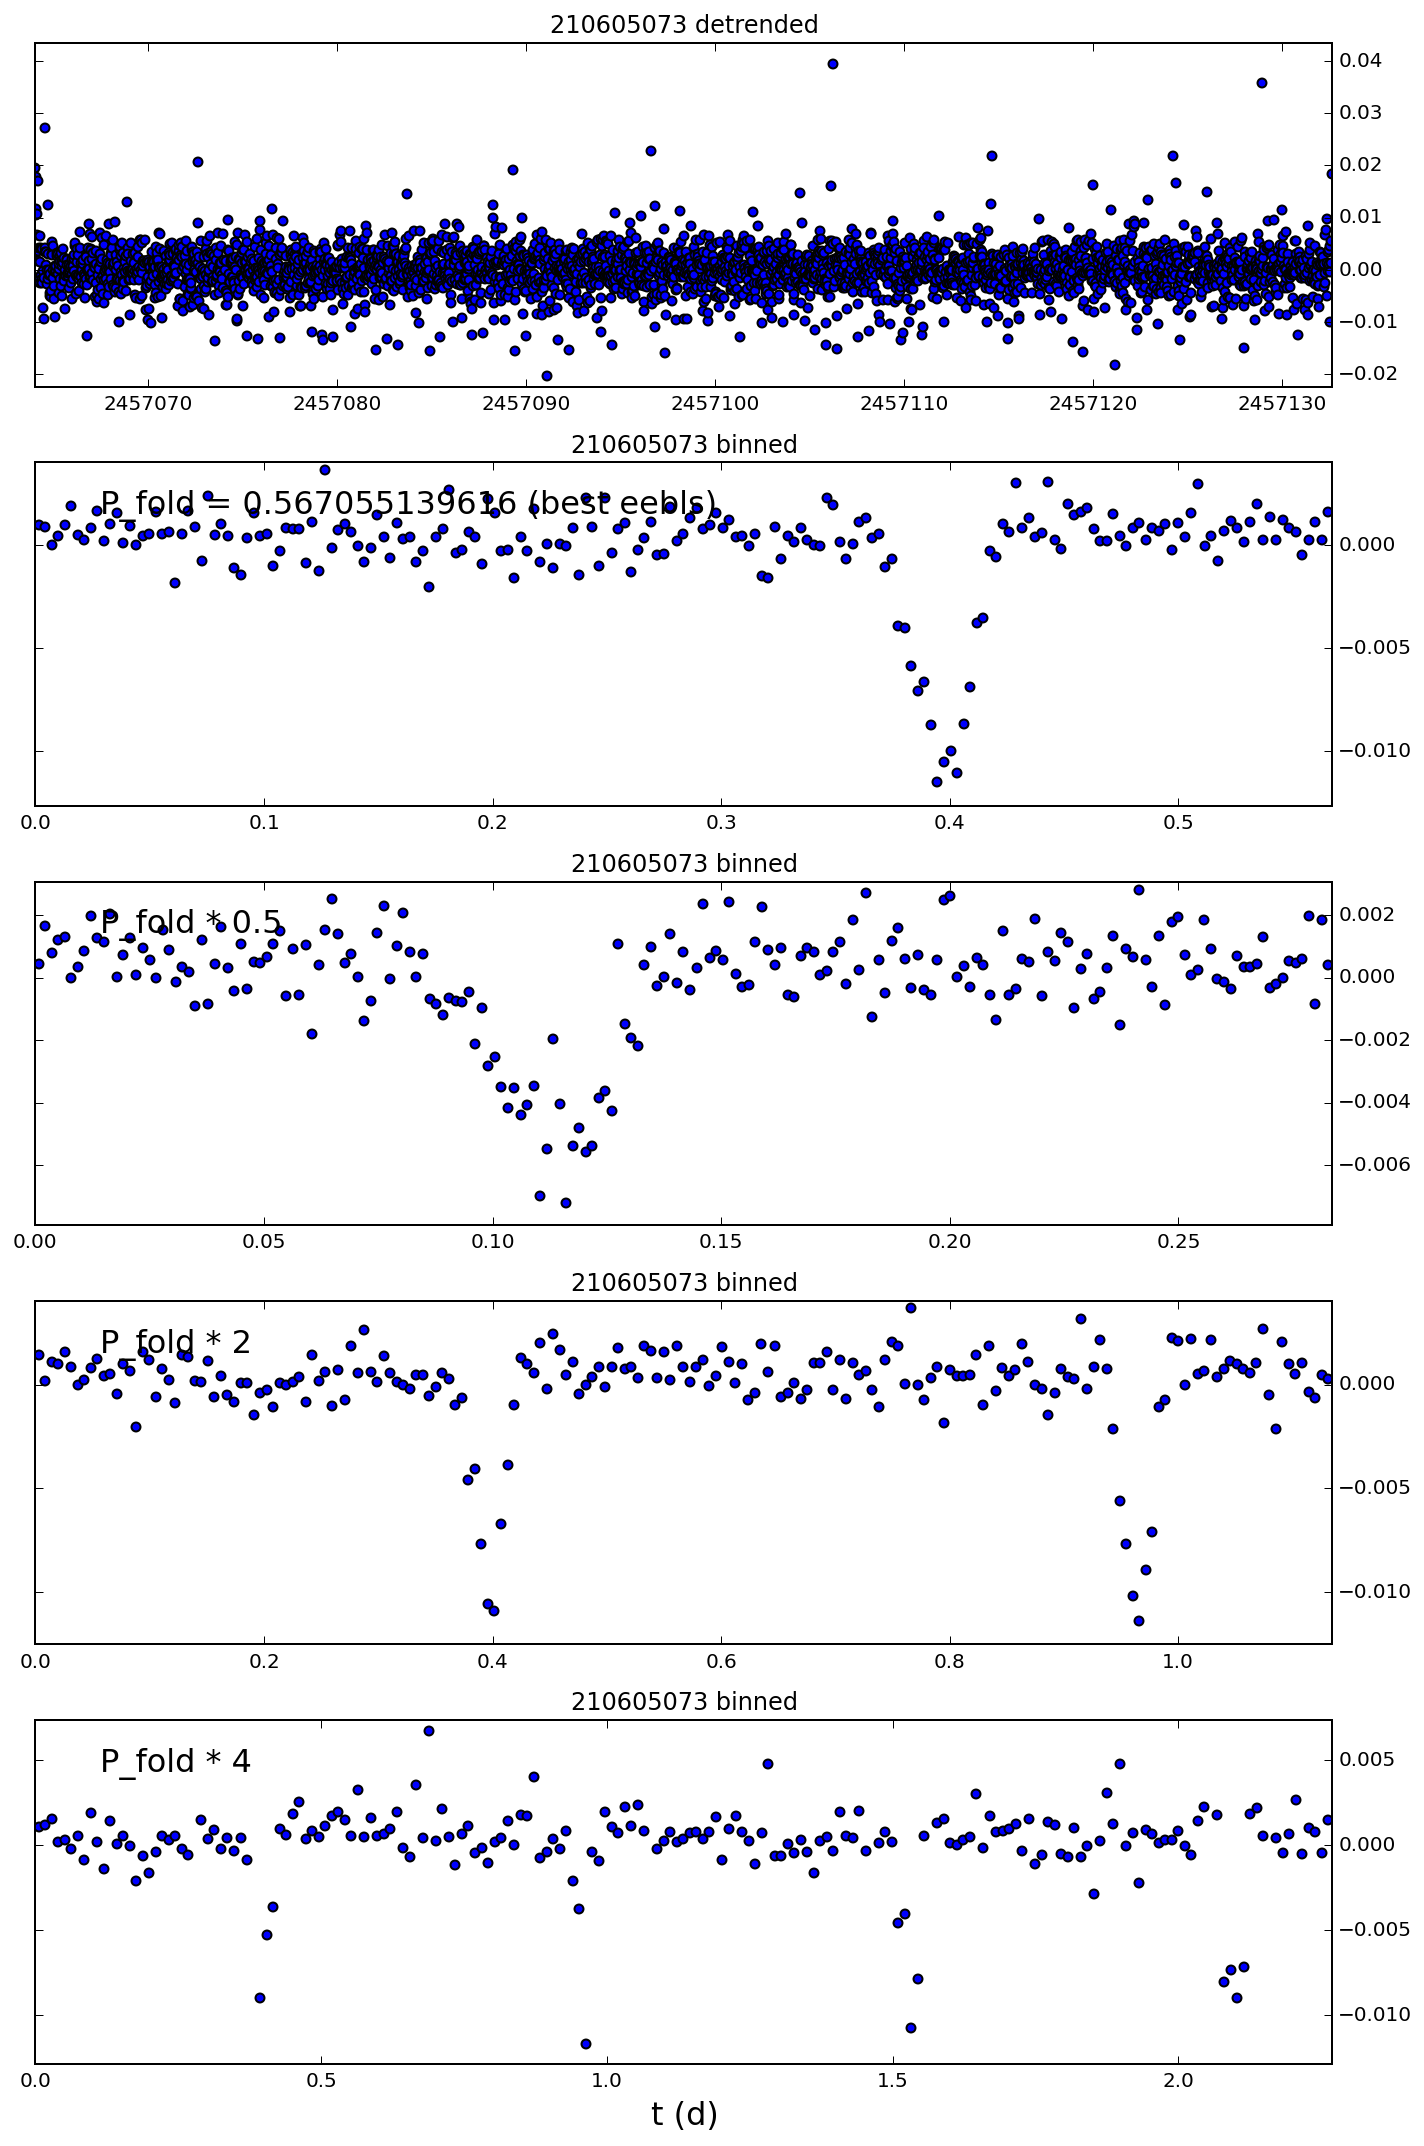

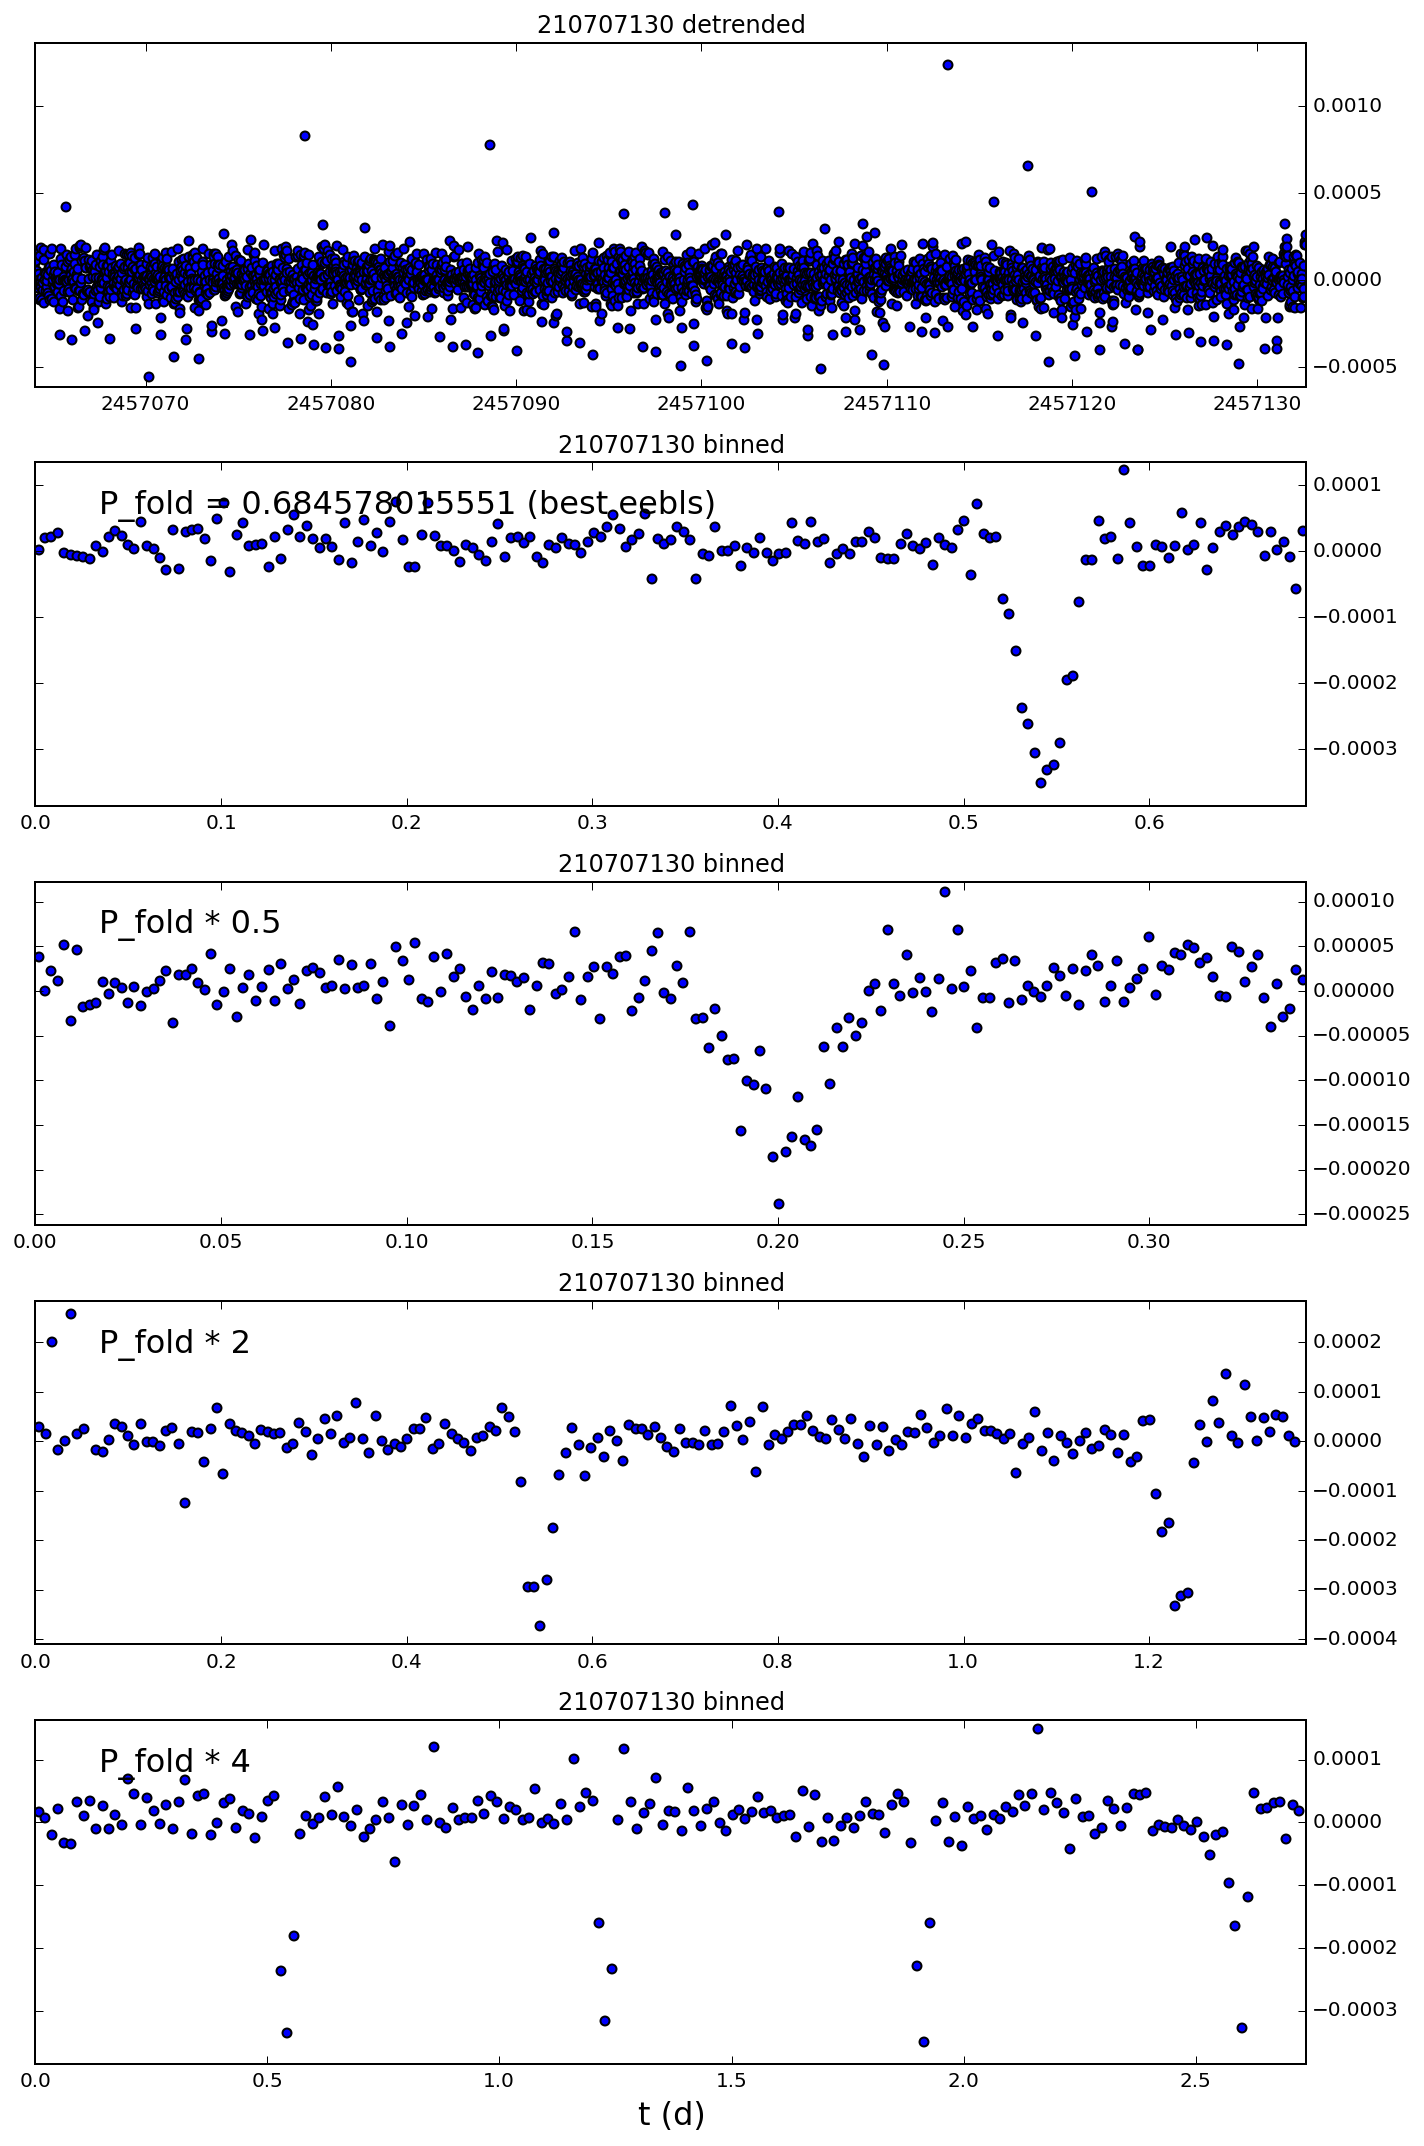

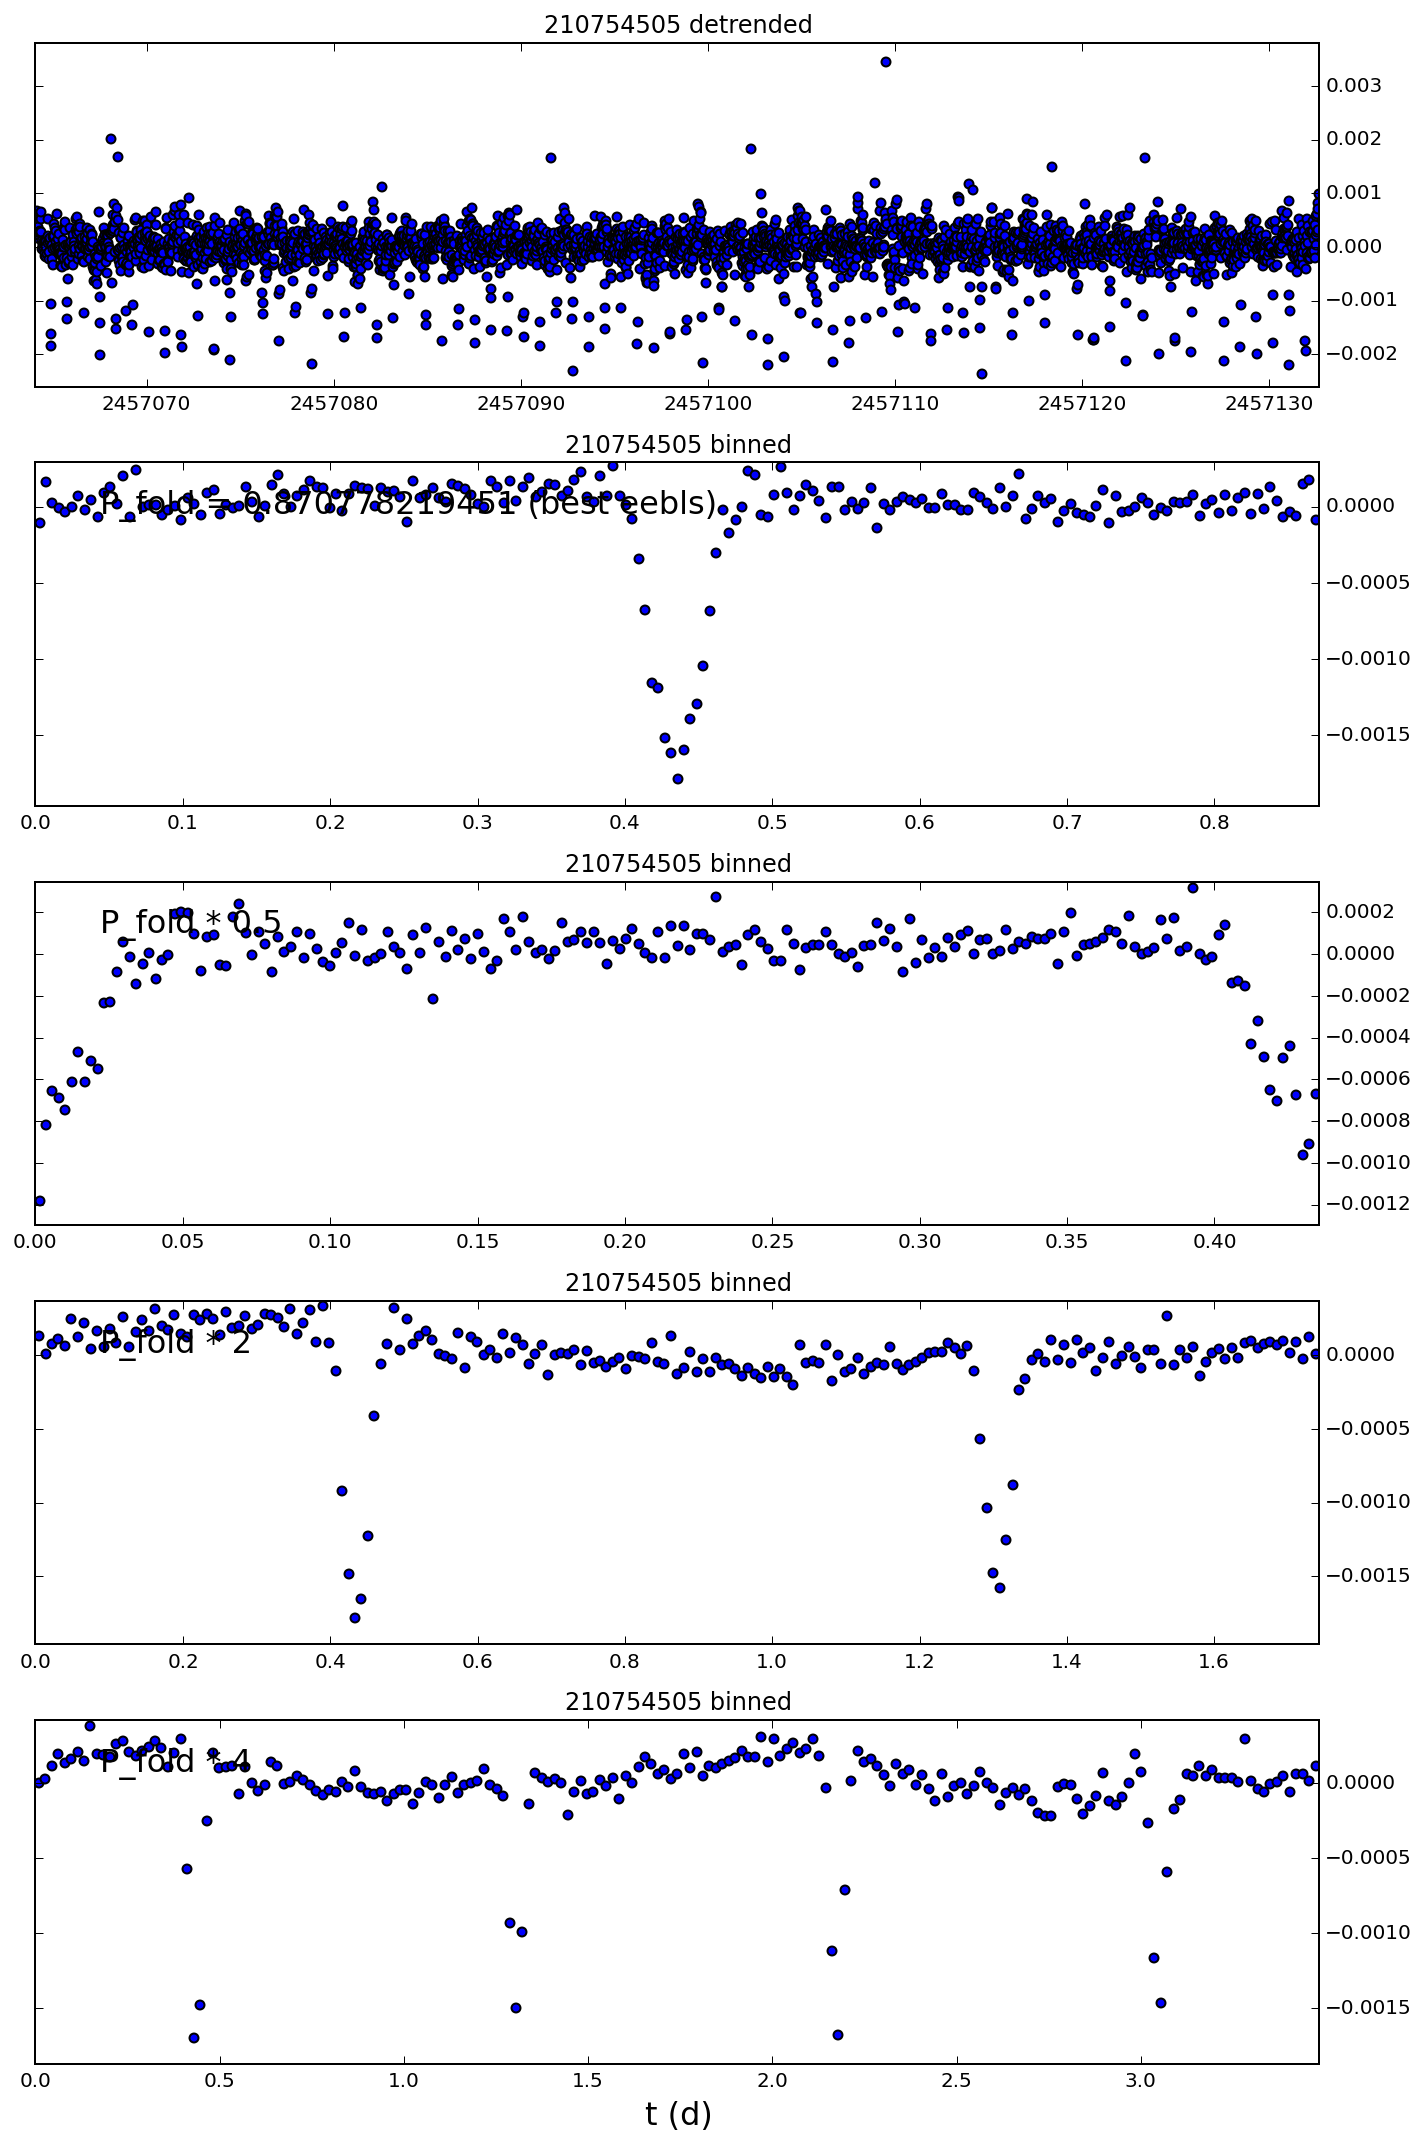

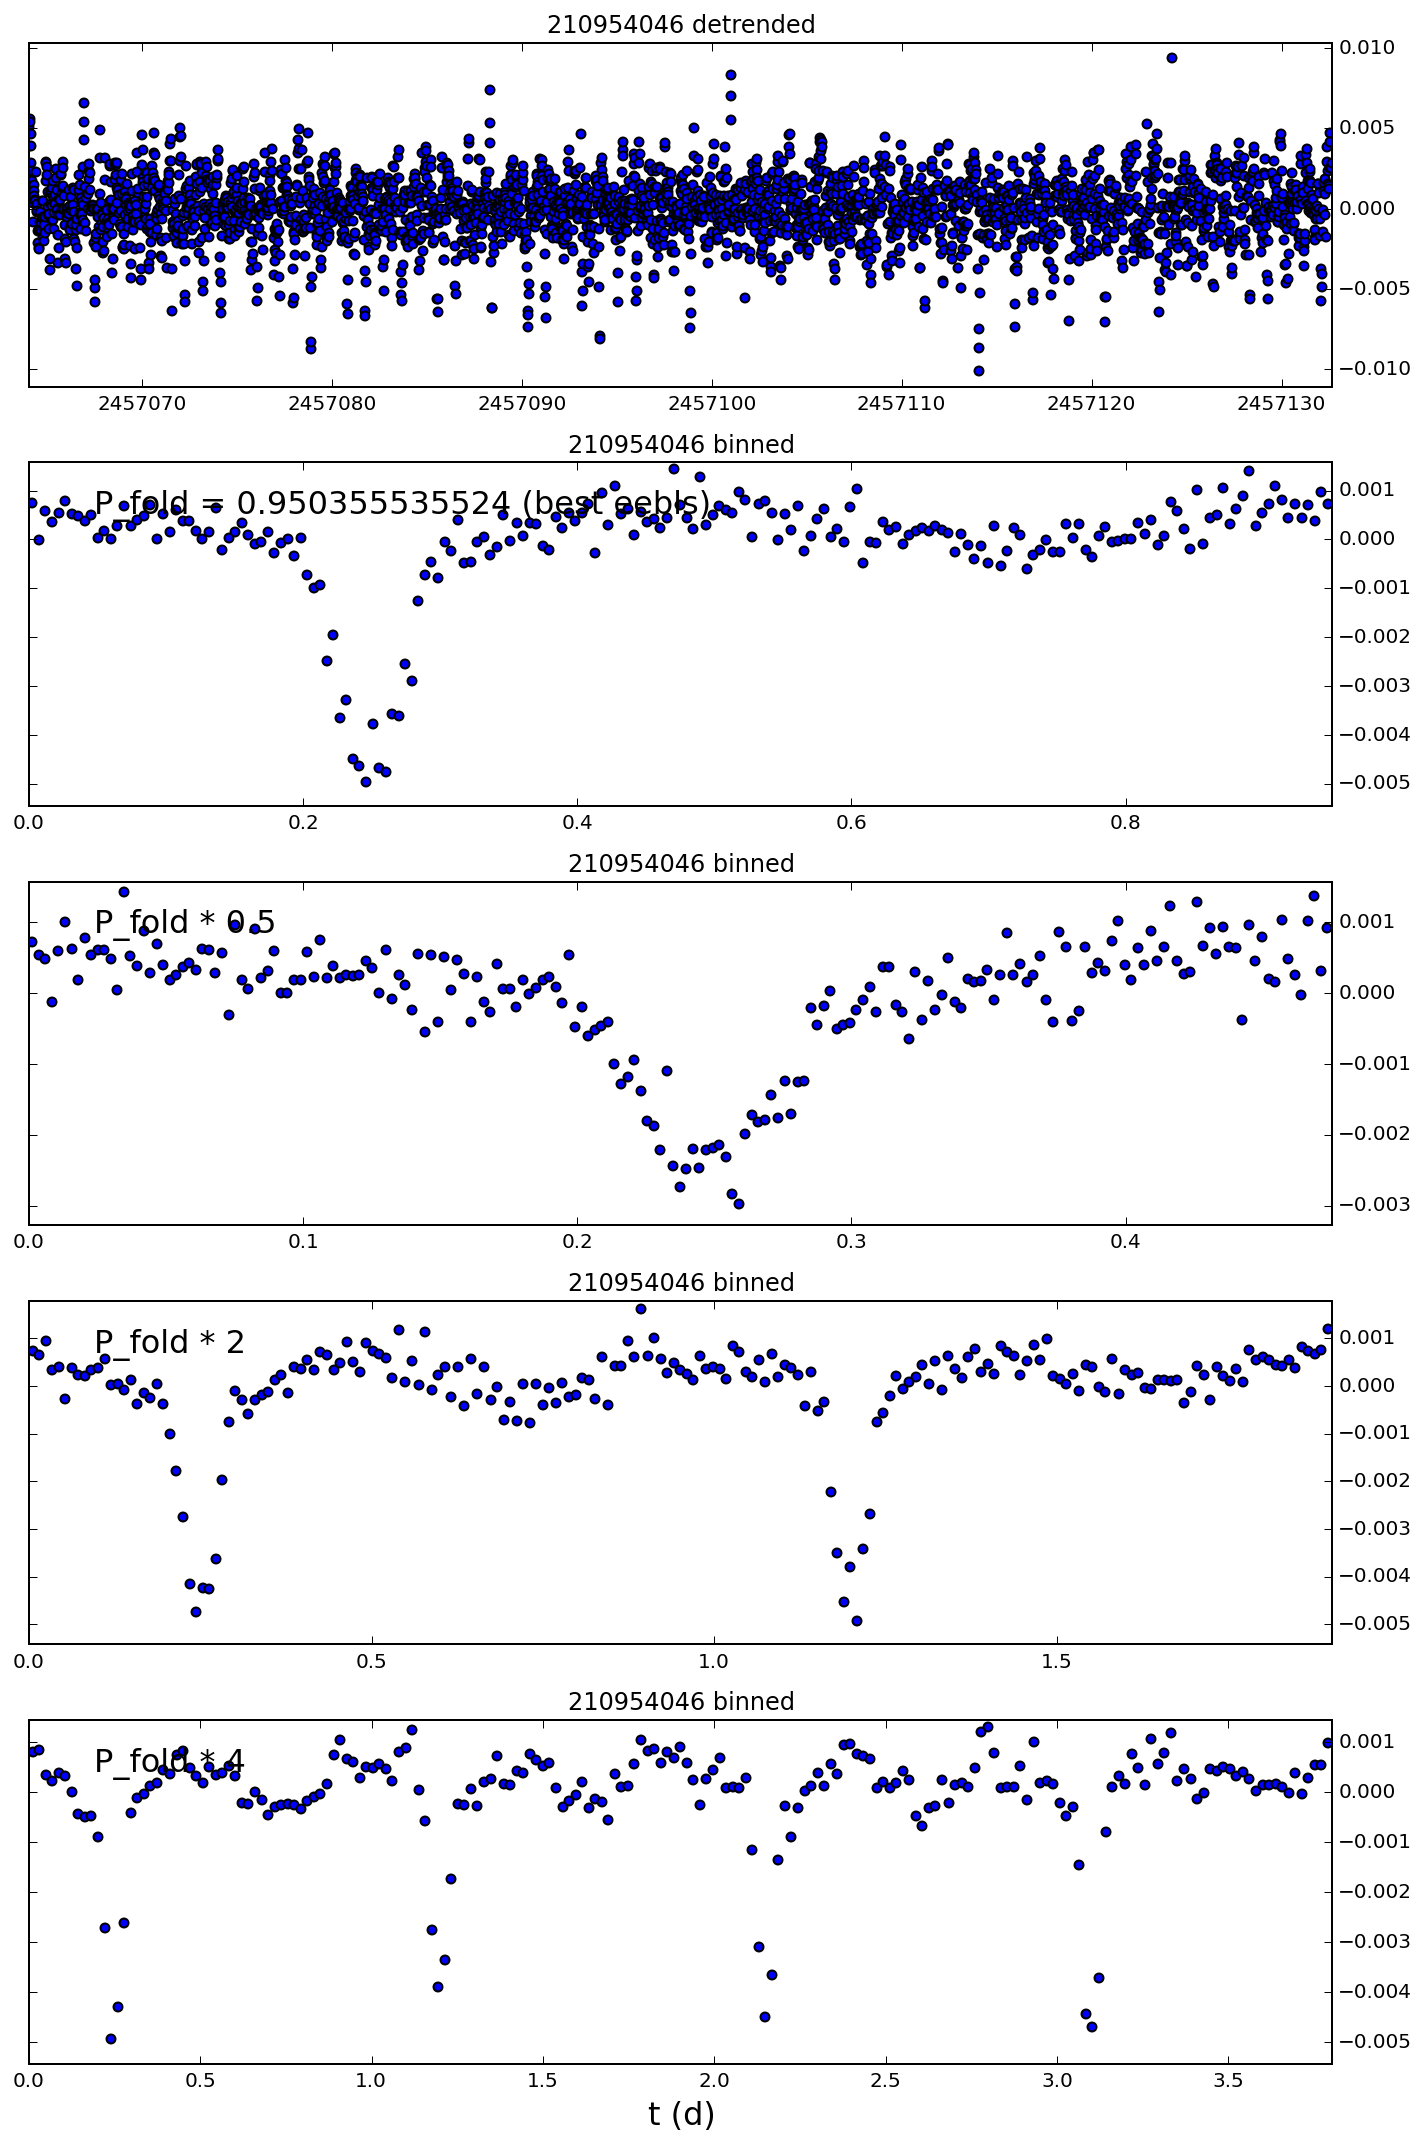

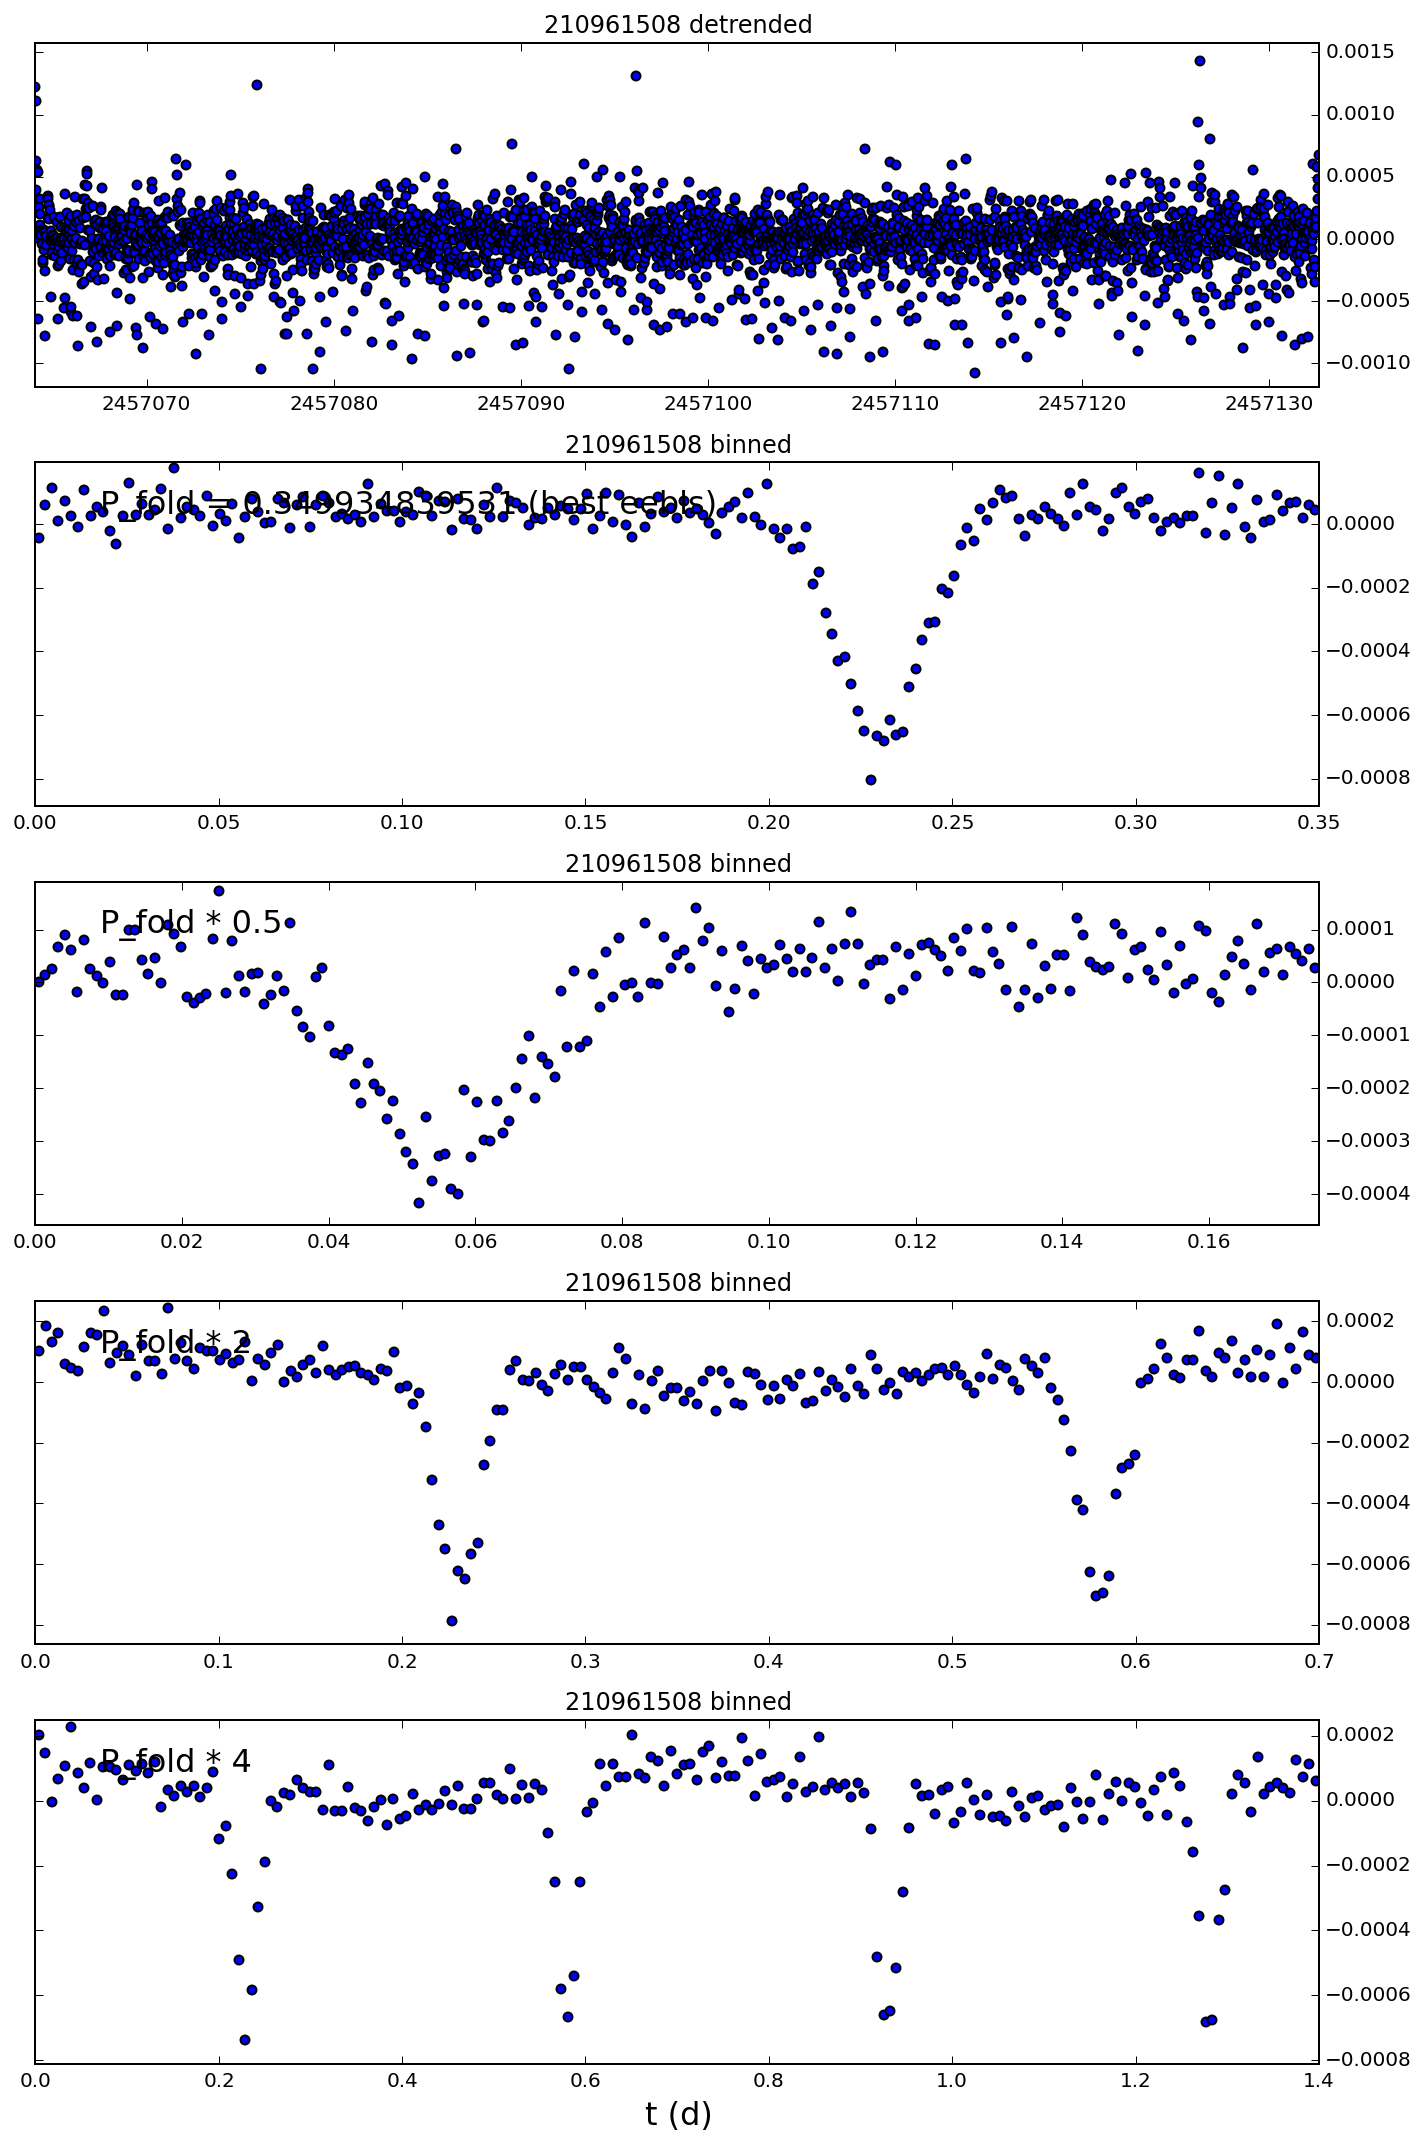

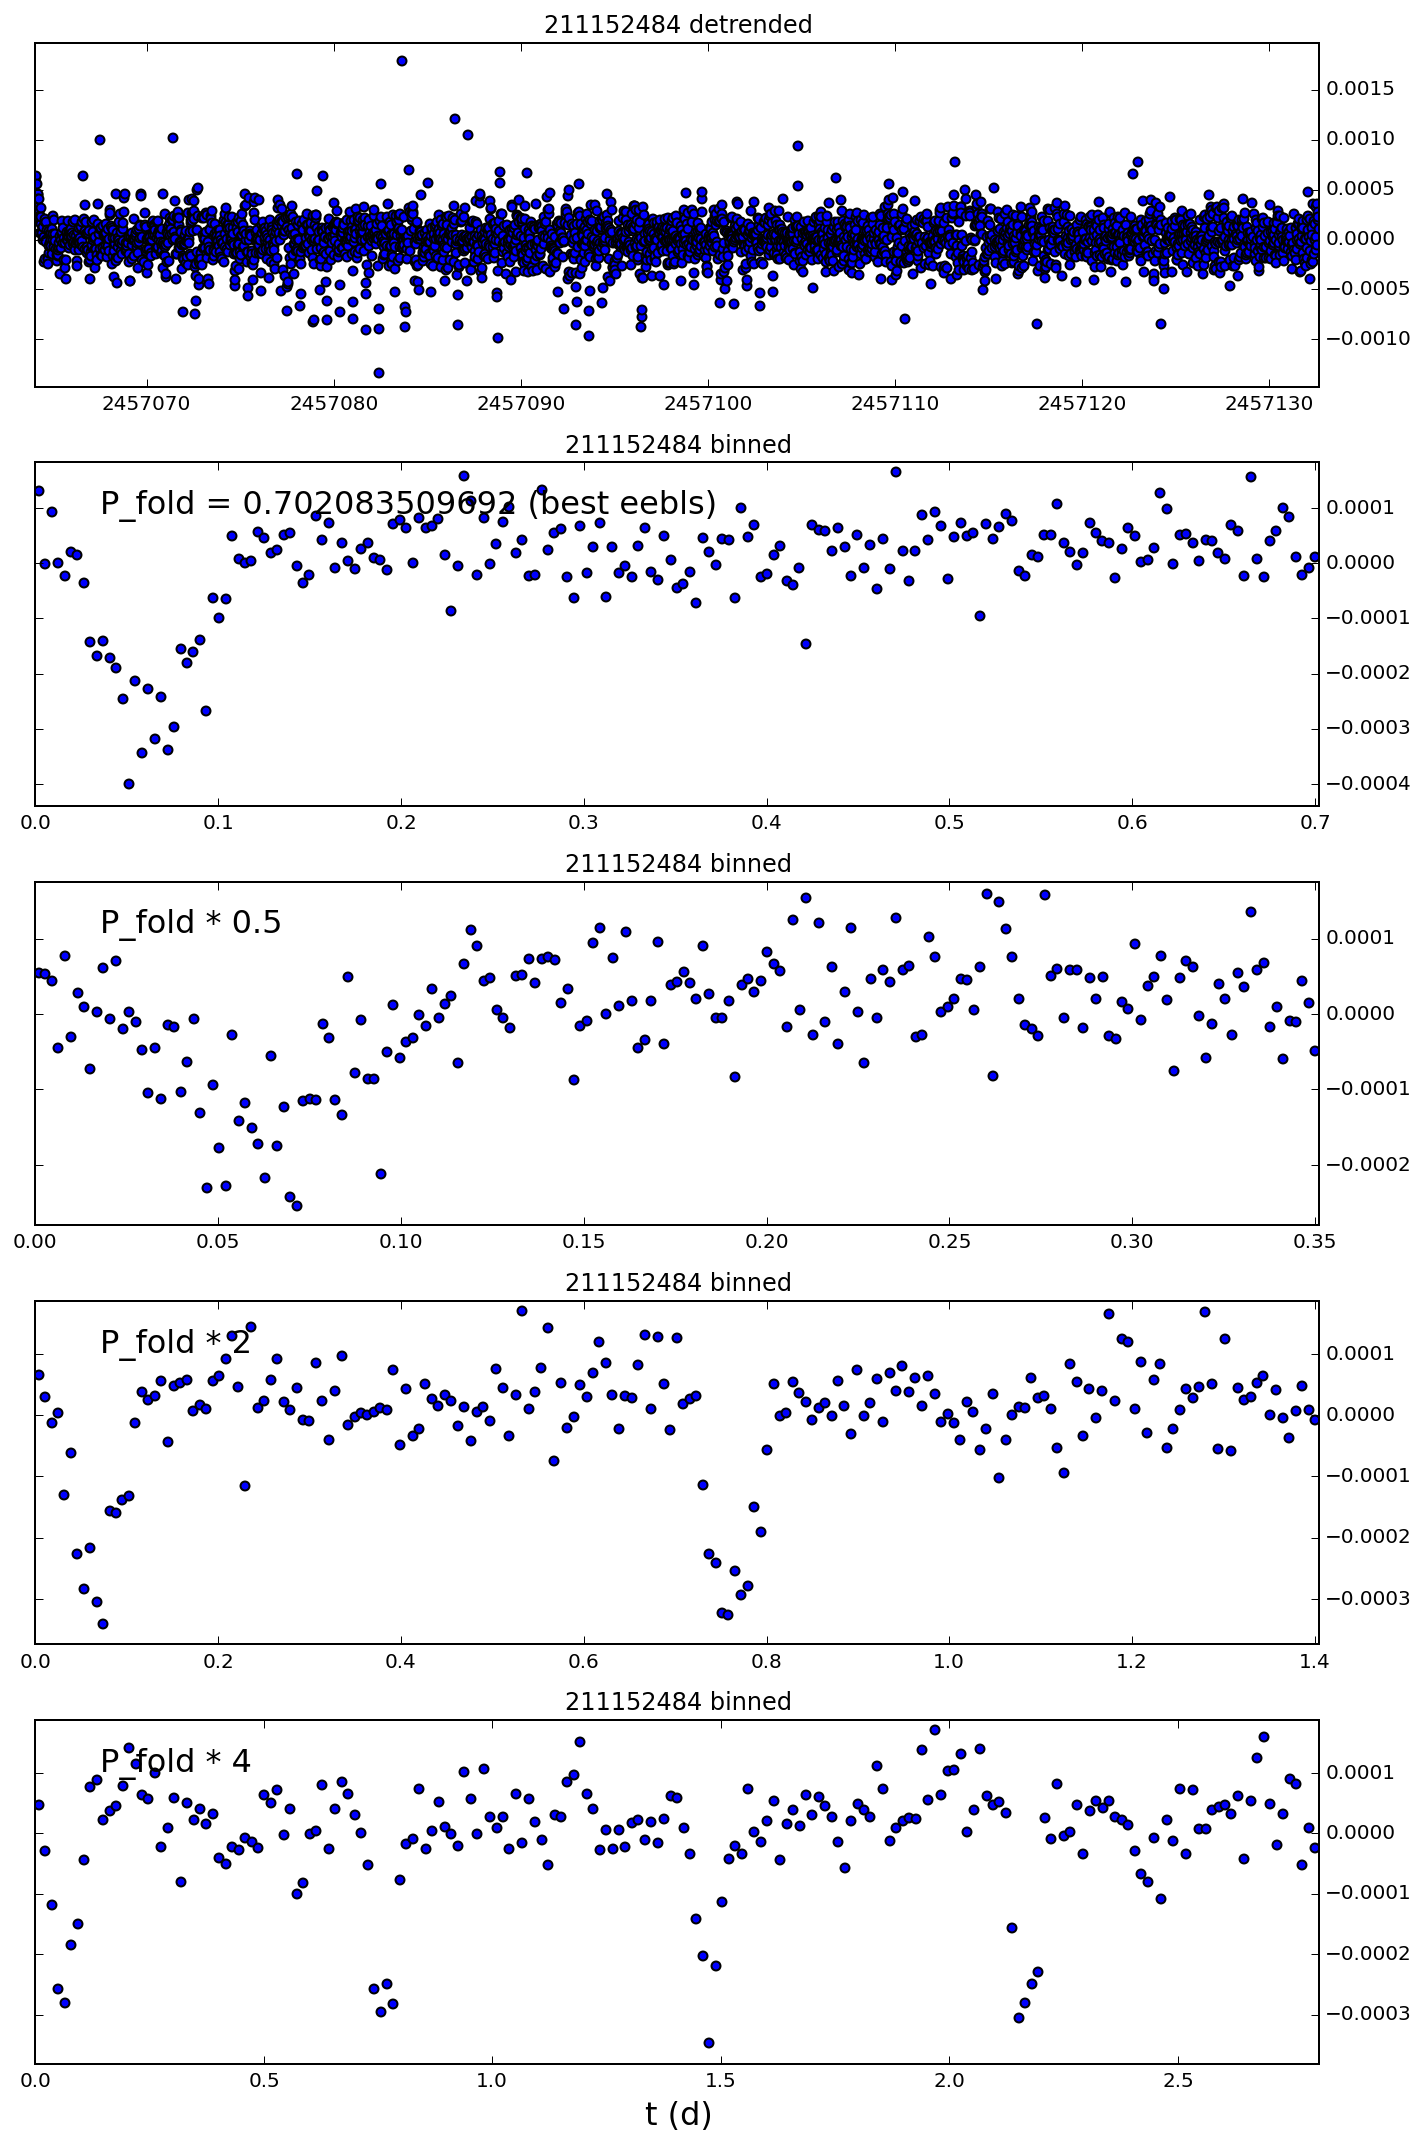

In [351]:
for ii,diagObj in enumerate(diag_objects):
    make_diag_plot(diagObj,  results_dir+"figures/diag/diag_"+str(diagObj)+".pdf",
                    extra_fold_factor=[0.5,2,4],plot_binned=True)
##### If you really just need to specify a period to test
#    pp = biggest_periods[10]
#    print diagObj, get_best_period_days(diagObj), pp
#    make_diag_plot(diagObj,  fileName="diag/diag/diag_"+str(diagObj)+".pdf",
#                   extra_fold_factor=[pp])

In [352]:
run_diag_ebs=False
if run_diag_ebs:
    for ii,diagObj in enumerate(eb_list):
        make_diag_plot(diagObj,  results_dir+"figures/diag/diag_"+str(diagObj)+".pdf",
                        extra_fold_factor=[0.5,2,4],plot_binned=True)

# Compile list of EBs with period and depth from EEBLS

All of the eclipsing binary depths are likely wrong and need to be rerun at higher SNR

In [353]:
# Need correct depths, which requires rerunning eebls search with --highersnr
gg=open(step0_dir+"all"+quarter+"_ebs","w")
for eb in eb_list:
    print >>gg,  eebls_results_dir + "hlsp_k2sff_k2_lightcurve_"+str(eb)+"-"+quarter+ fits_search_suffix 
gg.close()
# Then run (we don't need to save the output)
#    python k2_superpig_search.py --fl step0-inputs/alltest_ebs --highersnr 


In [354]:
# Objects which we have already identified as binaries at twice the original EEBLS period:
def true_period_factor(obj):
    if obj in [202087156 ,
               201182911, 201184068, 201523873, 201563164, 201680569, 201691826, 201810513, 201843069, 201848566, 201893576, 201903318,
               202073210, 202083924, 202088191, 202091545, 202103762,
               202828096, 202971774, 204538608, 204470067, 204822463, 205377483,
               205899208, 205910324, 205934874, 205978103, 205996447, 206100943, 206109113, 206315178, 206489474,
               210404228, 210593417, 210659779, 210663545, 210675130, 210754505, 210821360, 210941737, 210954667, 211012889,
               211380136, 211389268, 211518347, 211578677, 211580526, 211613886, 211623903,
               211719362, 211719484, 211796803, 211797674, 211822953, 211833449, 211833616,
               211931594, 211953866, 211995966, 211999656, 212066407, 212069706, 212158225]:
        return 2.0
    elif obj in [ ]:
        return 4.0
    else:
        return 1.0

In [355]:
eb_list

[210404228,
 210434247,
 210574135,
 210593417,
 210659779,
 210662654,
 210663545,
 210664740,
 210675130,
 210821360,
 210843708,
 210863062,
 210932768,
 210941737,
 210954667,
 211012889]

In [356]:
######## Make a plot of all EBs (at the correct period)
def make_eb_plot(cond_file_to_use="conditioned_data*.txt",longer=False):
    # Set number of rows/columns for plotting
    nCols = 4
    nPlots = len(eb_list)
    fig_length = 2*nPlots
   
    fig = pylab.figure(figsize=(10, fig_length))
     
    for ii,obj in enumerate(eb_list):
        best_period = get_best_period_days(obj,use_longer=longer,verbose=False)
        fold_period = best_period * true_period_factor(obj)
        detrended_time, detrended_flux = get_data(str(obj), root_dir=eebls_results_dir,
                                                  which_file=cond_file_to_use)
        binned_time, binned_flux, binned_err = k2_sppg.make_binned_transit(detrended_time % fold_period,
                                                                           detrended_flux, nb=200)

        ax2 = fig.add_subplot(nPlots, nCols, 1+ii)
        ax2.scatter(binned_time % fold_period, binned_flux)
       # ax2.text(0.05, 0.85, "P_fold = "+str(fold_period), fontsize=16,
        #         transform = ax2.transAxes)
        flux_diff = max(binned_flux) -min(binned_flux)
        
        ax2.set_ylim([min(binned_flux)-0.2*flux_diff,max(binned_flux)+0.2*flux_diff])
        ax2.set_xlim([0,fold_period])
        ax2.set_title(str(obj))
        ax2.yaxis.tick_right()
        ax2.yaxis.set_ticks_position('both')
        ax2.yaxis.set_label_position("right")
        ax2.locator_params(nbins=5)
    fig.tight_layout()
    pylab.savefig(results_dir+"figures/ebs/eb_"+quarter+".png", dpi=150, bbox_inches='tight')

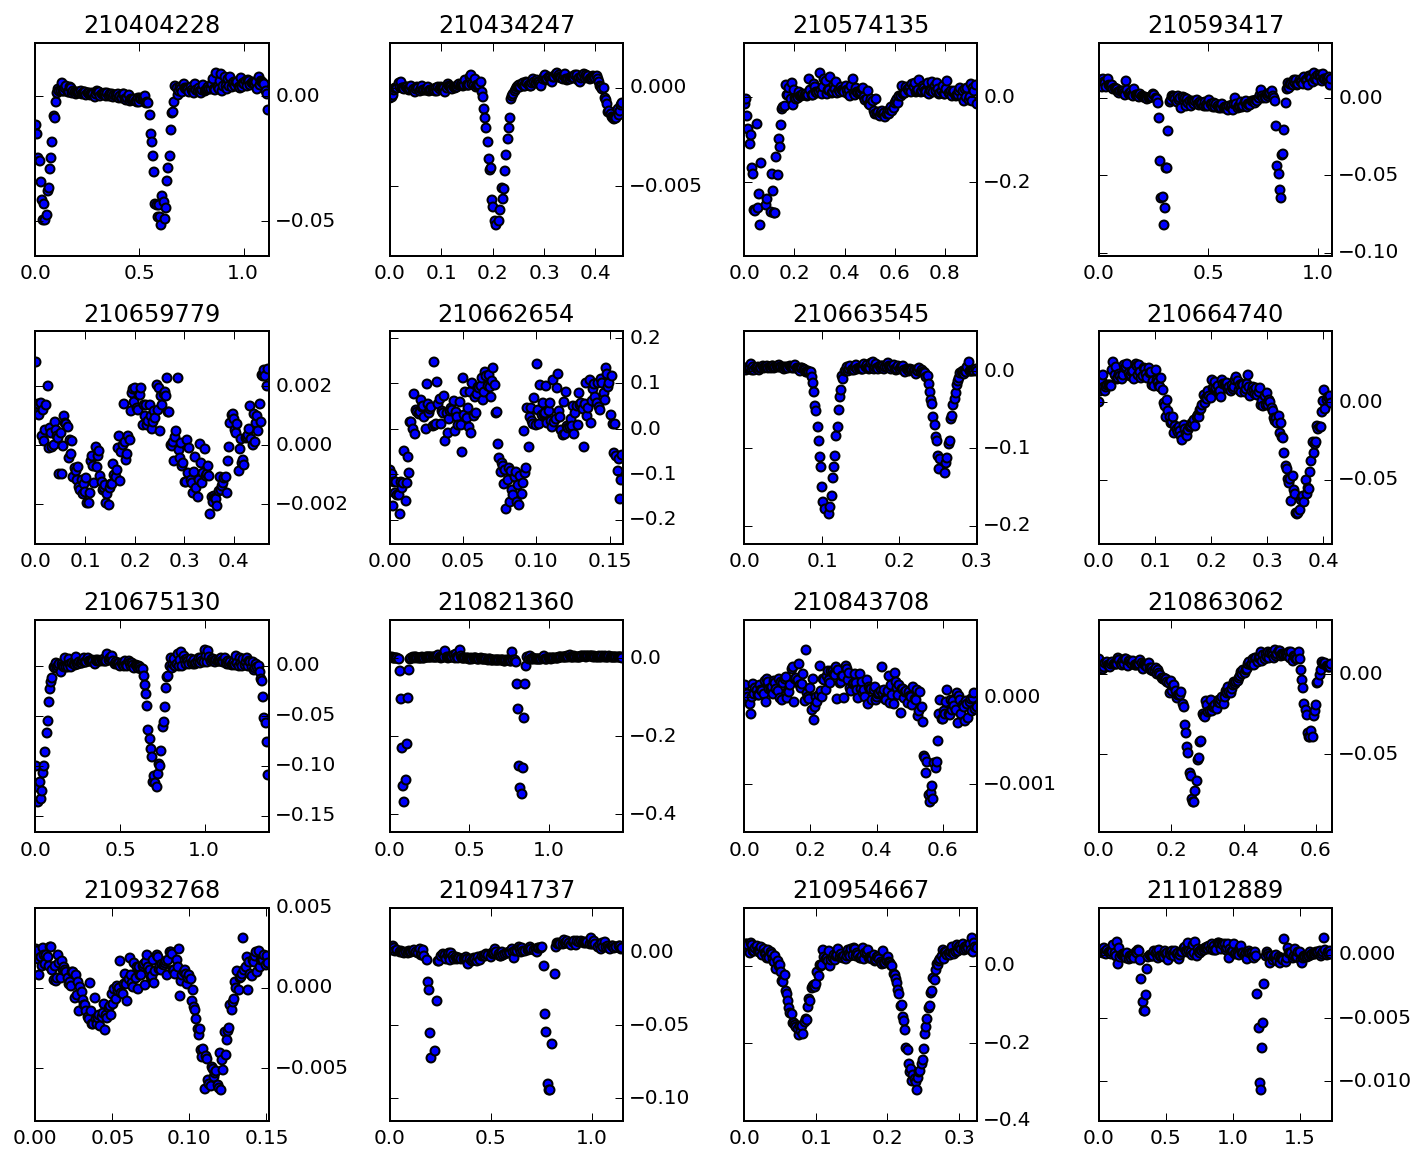

In [357]:
make_eb_plot()

In [358]:
eb_depths=[]
for eb in eb_list:
    if eb not in all_epic_nums:
        eb_depths.append( None )
    else:
        eb_ind = list(all_epic_nums).index(eb)
        eb_depths.append( all_depth[eb_ind] )

In [359]:
eb_period_file = results_dir+"figures/ebs/eb_periods_"+quarter+".tsv"
gg=open(eb_period_file,"w")
for ii,eb in enumerate(eb_list):
    best_period =  true_period_factor(eb)*get_best_period_days(eb,verbose=False)
    print >>gg, "\t".join([str(eb), str(best_period), str(true_period_factor(eb)), str(eb_depths[ii]) ])
gg.close()

# Export transit times, fluxes

In [360]:
def export_all_files(transit):
    for ii,ee in enumerate(follow_list):
        if ee == transit:
            fold_period = get_best_period_days(transit)
      
    detrended_time, detrended_flux = get_data(str(transit), root_dir=eebls_results_dir, which_file="conditioned_data*.txt")
    folded_time = detrended_time % fold_period
    folded_time_half = detrended_time % (0.5*fold_period)
    folded_time_double = detrended_time % (2.0*fold_period)
   
    print transit, fold_period, detrended_time[0], folded_time[0], detrended_flux[0]
    
    z = sorted(zip(folded_time, detrended_flux, folded_time_half, folded_time_double, detrended_time))
    sorted_folded_time, sorted_flux, sorted_half, sorted_double, sorted_time = zip(*z)
    
    lightcurve_file = lightcurve_dir+"lightcurve_"+str(transit)+".tsv"
    gg = open(lightcurve_file,"w")
    print >>gg, "T_folded","Flux","T_half","T_double","T_raw"
    
    for ii, tt in enumerate(list(sorted_folded_time)):
        print >>gg, "\t".join([str(tt),str(1+sorted_flux[ii]), 
                               str(sorted_half[ii]), str(sorted_double[ii]), str(sorted_time[ii])])
    gg.close()
    
    return detrended_time, detrended_flux

In [361]:
for transit in candidate_list:
#for transit in [203518244 ]:
    detrended_time, detrended_flux = export_all_files(transit)

period was refined
210414957 0.97001575141 2457064.04804 0.569501904343 0.0049639521
period was refined
210605073 0.567055139616 2457064.04818 0.518897534759 0.0195017751
period was refined
210707130 0.684578015551 2457064.04785 0.594668103259 9.83796e-05
period was refined
210754505 0.870778219451 2457064.04815 0.466444108126 0.0003845822
period was refined
210954046 0.950355535524 2457064.04799 0.591108339089 0.0039225605
period was refined
210961508 0.349934839531 2457064.04793 0.0715158683482 0.0012195823
period was refined
211152484 0.702083509692 2457064.04794 0.643243284683 0.0005825667


In [362]:
len(follow_list)

7

In [363]:
promising_dir

'step2-candidate-results/promising-c04-2016Feb22/'

In [364]:
files_in_folder(promising_dir+"_transit-like/")

[210414957, 210605073, 210707130, 210754505, 210954046, 210961508, 211152484]